# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 Business Understanding</span>

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <h3 style="color:black; text-align:center;">Yarışmanın Temel Amacı</h3>
  <ul>
    <li>Yarışmanın temel amacı, eğitim verilerimizi kullanarak <strong>sii</strong> değerini tahmin etmektir. Bu, Problemli İnternet Kullanımı'nın (PIU) standart bir ölçüsüdür.</li>
    <li>Eğitim verileri, 81 sütun (ID sütunu hariç) içeren, çocuklar ve gençlerden oluşan toplam <strong>3.960 kayıt</strong> içermektedir. Verilerde özellikle <strong>Ebeveyn-Çocuk İnternet Bağımlılığı Testi (PCIAT)</strong> sonuçları büyük önem taşımaktadır.</li>
    <li>Hedef değişken, aslında <strong>PCIAT_Total</strong> alanından (100 üzerinden puanlanmış) türetilmiştir. Bu nedenle, <strong>PCIAT Total</strong> değerini tahmin etmeyi seçebilir ve bunu <strong>sii</strong>'ye dönüştürebiliriz (bunu bir regresyon problemi haline getirir) veya doğrudan <strong>sii</strong>'yi tahmin etmeyi tercih edebiliriz (bunu bir sınıflandırma problemi haline getirir).</li>
    <li>Test verisi, yalnızca biçimlendirilmiş örnek verilerden oluşmaktadır. Yaklaşık <strong>3.800 kayıttan</strong> oluşan gerçek test verisi gizlenmiştir. Örnek verilerde, hedef değişkenin yanı sıra <strong>22 PCIAT alanının</strong> hiçbiri bulunmamaktadır. Bu nedenle, örnek veri biçimi, eğitim verisine kıyasla <strong>81 sütun</strong> yerine yalnızca <strong>58 sütun</strong> içermektedir.</li>
    <li>Eğitim verisindeki <strong>1.224 kayıtta</strong>, <strong>sii</strong> hedefi ve tüm PCIAT sütunları eksiktir. Genel olarak, eğitim verilerinde <strong>100.000'den fazla eksik değer</strong> bulunmaktadır. Hedef değişkene sahip olan kayıt sayısı sadece <strong>2.736</strong>, geri kalanları eksiktir.</li>
    <li>Ayrıca, <strong>996 kişinin</strong>, saat verilerinden alınan zaman serisi bilgileri elimizde mevcuttur. Her kişinin zaman serisi verisinde <strong>13 sütun</strong> ve yaklaşık <strong>20.000-400.000</strong> aralığında kayıt bulunmaktadır. Bu veriler her kişinin ID klasörünün altında Parquet dosyalarında tutulmaktadır.</li>
  </ul>
</div>

# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📤 Veri Setlerinin ve Gerekli Kütüphanelerin İmport Edilmesi </span>

In [1]:
pip install numpy pandas polars seaborn colorama

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scipy scikit-learn tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install lightgbm xgboost catboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pyarrow fastparquet

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import re
import glob
import warnings
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs
import seaborn as sns
from colorama import Fore, Style
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
from scipy.optimize import minimize
from sklearn.base import clone
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor,
                               VotingRegressor)
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import ElasticNetCV, Lasso, LassoCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from scipy.optimize import minimize
import optuna
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
import random
import pickle

C:\Users\Ali Can\anaconda3\envs\Kaggle\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
#Dataframe Şekillendirme ve Uyarı Filtreleme
pd.set_option("display.max_columns",None)
pd.set_option("display.width",600)
pd.set_option("display.max_rows",600)
pd.set_option("display.float_format",lambda x:"%.2f" %x)
warnings.filterwarnings("ignore")

In [8]:
train_file_path = 'train.csv'
test_file_path = 'test.csv'

train_ts = 'series_train.parquet'
test_ts = 'series_test.parquet'


train = pd.read_csv(train_file_path)
test = pd.read_csv(test_file_path)

In [9]:
train.shape

(3960, 82)

In [10]:
test.shape

(20, 59)

# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 train.csv ve test.csv  </span>

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <h3 style="color:black; text-align:center;">SII Tahmini ve PCIAT Testi</h3>
  <p>Bu yarışmadaki hedef, çocuklar ve ergenler arasındaki problemli internet kullanımının seviyesini ölçen <strong>Severity Impairment Index (sii)</strong> değerini tahmin etmektir. Bu tahmin, fiziksel aktivite verileri ve diğer ilgili özelliklere dayanarak yapılmaktadır.</p>
  <p><strong>sii</strong> puanı, <strong>Ebeveyn-Çocuk İnternet Bağımlılığı Testi (PCIAT)</strong>'nden türetilir. Bu test, 20 sorudan oluşur ve her soru 0 ile 5 arasında puanlanır. Soruların toplam puanı <strong>PCIAT-PCIAT_Total</strong> olarak adlandırılır.</p>
  <h4>Hedef Değişken (sii) Tanımı</h4>
  <ul>
    <li><strong>0: None</strong> (PCIAT-PCIAT_Total 0 ile 30 arasında)</li>
    <li><strong>1: Mild</strong> (PCIAT-PCIAT_Total 31 ile 49 arasında)</li>
    <li><strong>2: Moderate</strong> (PCIAT-PCIAT_Total 50 ile 79 arasında)</li>
    <li><strong>3: Severe</strong> (PCIAT-PCIAT_Total 80 ve üstü)</li>
  </ul>
  <p>Bu kategoriler, <strong>sii</strong> değişkenini sıralamanın önemli olduğu ordinal bir kategorik değişken haline getirmektedir.</p>
</div>

In [11]:
# sii kategorilerine göre PCIAT toplam puanlarının minimum ve maksimum değerlerini hesapla
def calculate_pciat_range_by_sii(df, target_col='sii', score_col='PCIAT-PCIAT_Total'):
    pciat_range = df.groupby(target_col)[score_col].agg(['min', 'max'])

    pciat_range = pciat_range.rename(
        columns={'min': 'En Düşük PCIAT Puanı', 'max': 'En Yüksek PCIAT Puanı'}
    )

    return pciat_range

In [12]:
calculate_pciat_range_by_sii(train)

,En Düşük PCIAT Puanı,En Yüksek PCIAT Puanı
sii,,
0.00,0.00,30.00
1.00,31.00,49.00
2.00,50.00,79.00
3.00,80.00,93.00


<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <h3 style="color:black; text-align:center;">PCIAT Sınır Değer Analizi</h3>
  <ul>
    <li> Her eksik PCIAT sorusu için +5 ekleyerek SII kategorisinin değişip değişmediğini kontrol eder, eğer değişiyorsa bunları sınır değer kabul edip siler. Ayrıyetten tüm PCIAT soruları NaN ise, bu satırları da siler.</li>
  </ul>
</div>


In [13]:
def get_missing_pciat_rows(train_df):
    pciat_columns = [f'PCIAT-PCIAT_{i:02d}' for i in range(1, 21)]
    selected_columns = pciat_columns + ['PCIAT-PCIAT_Total', 'sii']
    
    df_pciat = train_df[selected_columns]
    missing_rows = df_pciat[df_pciat[pciat_columns].isnull().any(axis=1)]
    
    print(f"Toplam Satır Sayısı (Eksik PCIAT Değerleri Olan): {len(missing_rows)}")
    
    return missing_rows

In [14]:
get_missing_pciat_rows(train)

Toplam Satır Sayısı (Eksik PCIAT Değerleri Olan): 1289


,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,sii
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3952,3.00,2.00,4.00,2.00,3.00,1.00,4.00,2.00,2.00,2.00,2.00,1.00,NaN,1.00,1.00,1.00,1.00,1.00,1.00,1.00,35.00,1.00
3956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
def clean_pciat_missing_rows(train_df):
    pciat_columns = [f'PCIAT-PCIAT_{i:02d}' for i in range(1, 21)]
    selected_columns = pciat_columns + ['PCIAT-PCIAT_Total', 'sii']
    
    df_pciat = train_df[selected_columns]
    nan_pciat_rows = df_pciat[df_pciat[pciat_columns].isnull().any(axis=1)]
    
    def is_sii_changed(row):
        """
        Her eksik PCIAT sorusu için +5 ekleyerek SII kategorisinin değişip değişmediğini kontrol eder.
        """
        original_total = row['PCIAT-PCIAT_Total']
        sii = row['sii']
        missing_count = row[pciat_columns].isnull().sum()
        
        adjusted_total = original_total + (missing_count * 5)
        
        # SII kategorisinin değişip değişmediğini kontrol eder
        if sii == 0 and adjusted_total >= 31:
            return True
        elif sii == 1 and adjusted_total >= 50:
            return True
        elif sii == 2 and adjusted_total >= 80:
            return True
        elif sii == 3 and adjusted_total < 80:
            return True
        return False

    # Sınır değerini aşan satırları tespit eder
    rows_to_remove_due_to_sii = nan_pciat_rows.apply(is_sii_changed, axis=1)
    
    # Tüm PCIAT soruları NaN olan satırları tespit eder
    all_pciat_nan_rows = df_pciat[pciat_columns].isnull().all(axis=1)
    
    # Silinecek satırların birleşimi
    rows_to_remove = nan_pciat_rows[rows_to_remove_due_to_sii].index
    all_nan_rows_to_remove = df_pciat[all_pciat_nan_rows].index
    total_rows_to_remove = set(rows_to_remove).union(set(all_nan_rows_to_remove))
    
    cleaned_df = train_df.drop(index=total_rows_to_remove)
    
    print(f"SII kategorisini değiştiren silinen satır sayısı: {len(rows_to_remove)}")
    print(f"Tüm PCIAT soruları NaN olan silinen satır sayısı: {len(all_nan_rows_to_remove)}")
    print(f"Toplam Silinen Satır Sayısı: {len(total_rows_to_remove)}")
    print(f"Temizlenmiş Veri Satır Sayısı: {len(cleaned_df)}")
    
    return cleaned_df

In [16]:
train = clean_pciat_missing_rows(train)

SII kategorisini değiştiren silinen satır sayısı: 17
Tüm PCIAT soruları NaN olan silinen satır sayısı: 1225
Toplam Silinen Satır Sayısı: 1241
Temizlenmiş Veri Satır Sayısı: 2719


<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;text-align:center;">
  <h3 style="color:black;margin:0;">PCIAT Değerleri ve "sii" Değerlerinin Karşılaştırılması</h3>
</div>

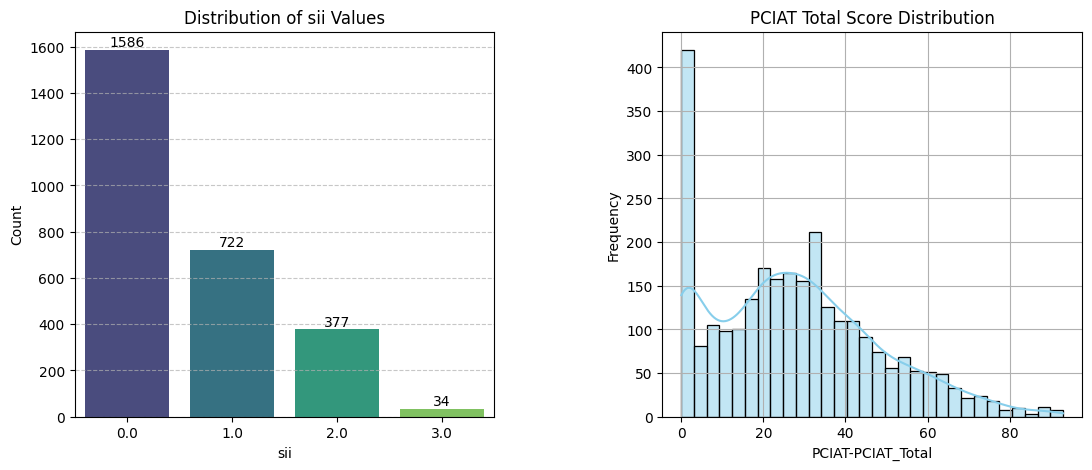

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
plt.subplots_adjust(wspace=0.4)

sii_counts = train['sii'].value_counts().sort_index()
sns.barplot(ax=axes[0], x=sii_counts.index, y=sii_counts.values, palette='viridis')

for idx, value in enumerate(sii_counts.values):
    axes[0].text(x=idx, y=value + 1, s=str(value), ha='center', va='bottom')

axes[0].set_title('Distribution of sii Values')
axes[0].set_xlabel('sii')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

if 'PCIAT-PCIAT_Total' in train.columns:
    sns.histplot(train['PCIAT-PCIAT_Total'].dropna(), bins=30, kde=True, color='skyblue', ax=axes[1])
    axes[1].set_title('PCIAT Total Score Distribution')
    axes[1].set_xlabel('PCIAT-PCIAT_Total')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True)

# Grafikleri göster
plt.show()

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;text-align:center;">
  <h3 style="color:black;margin:0;">Aykırı Değerlerin İncelenmesi</h3>
</div>

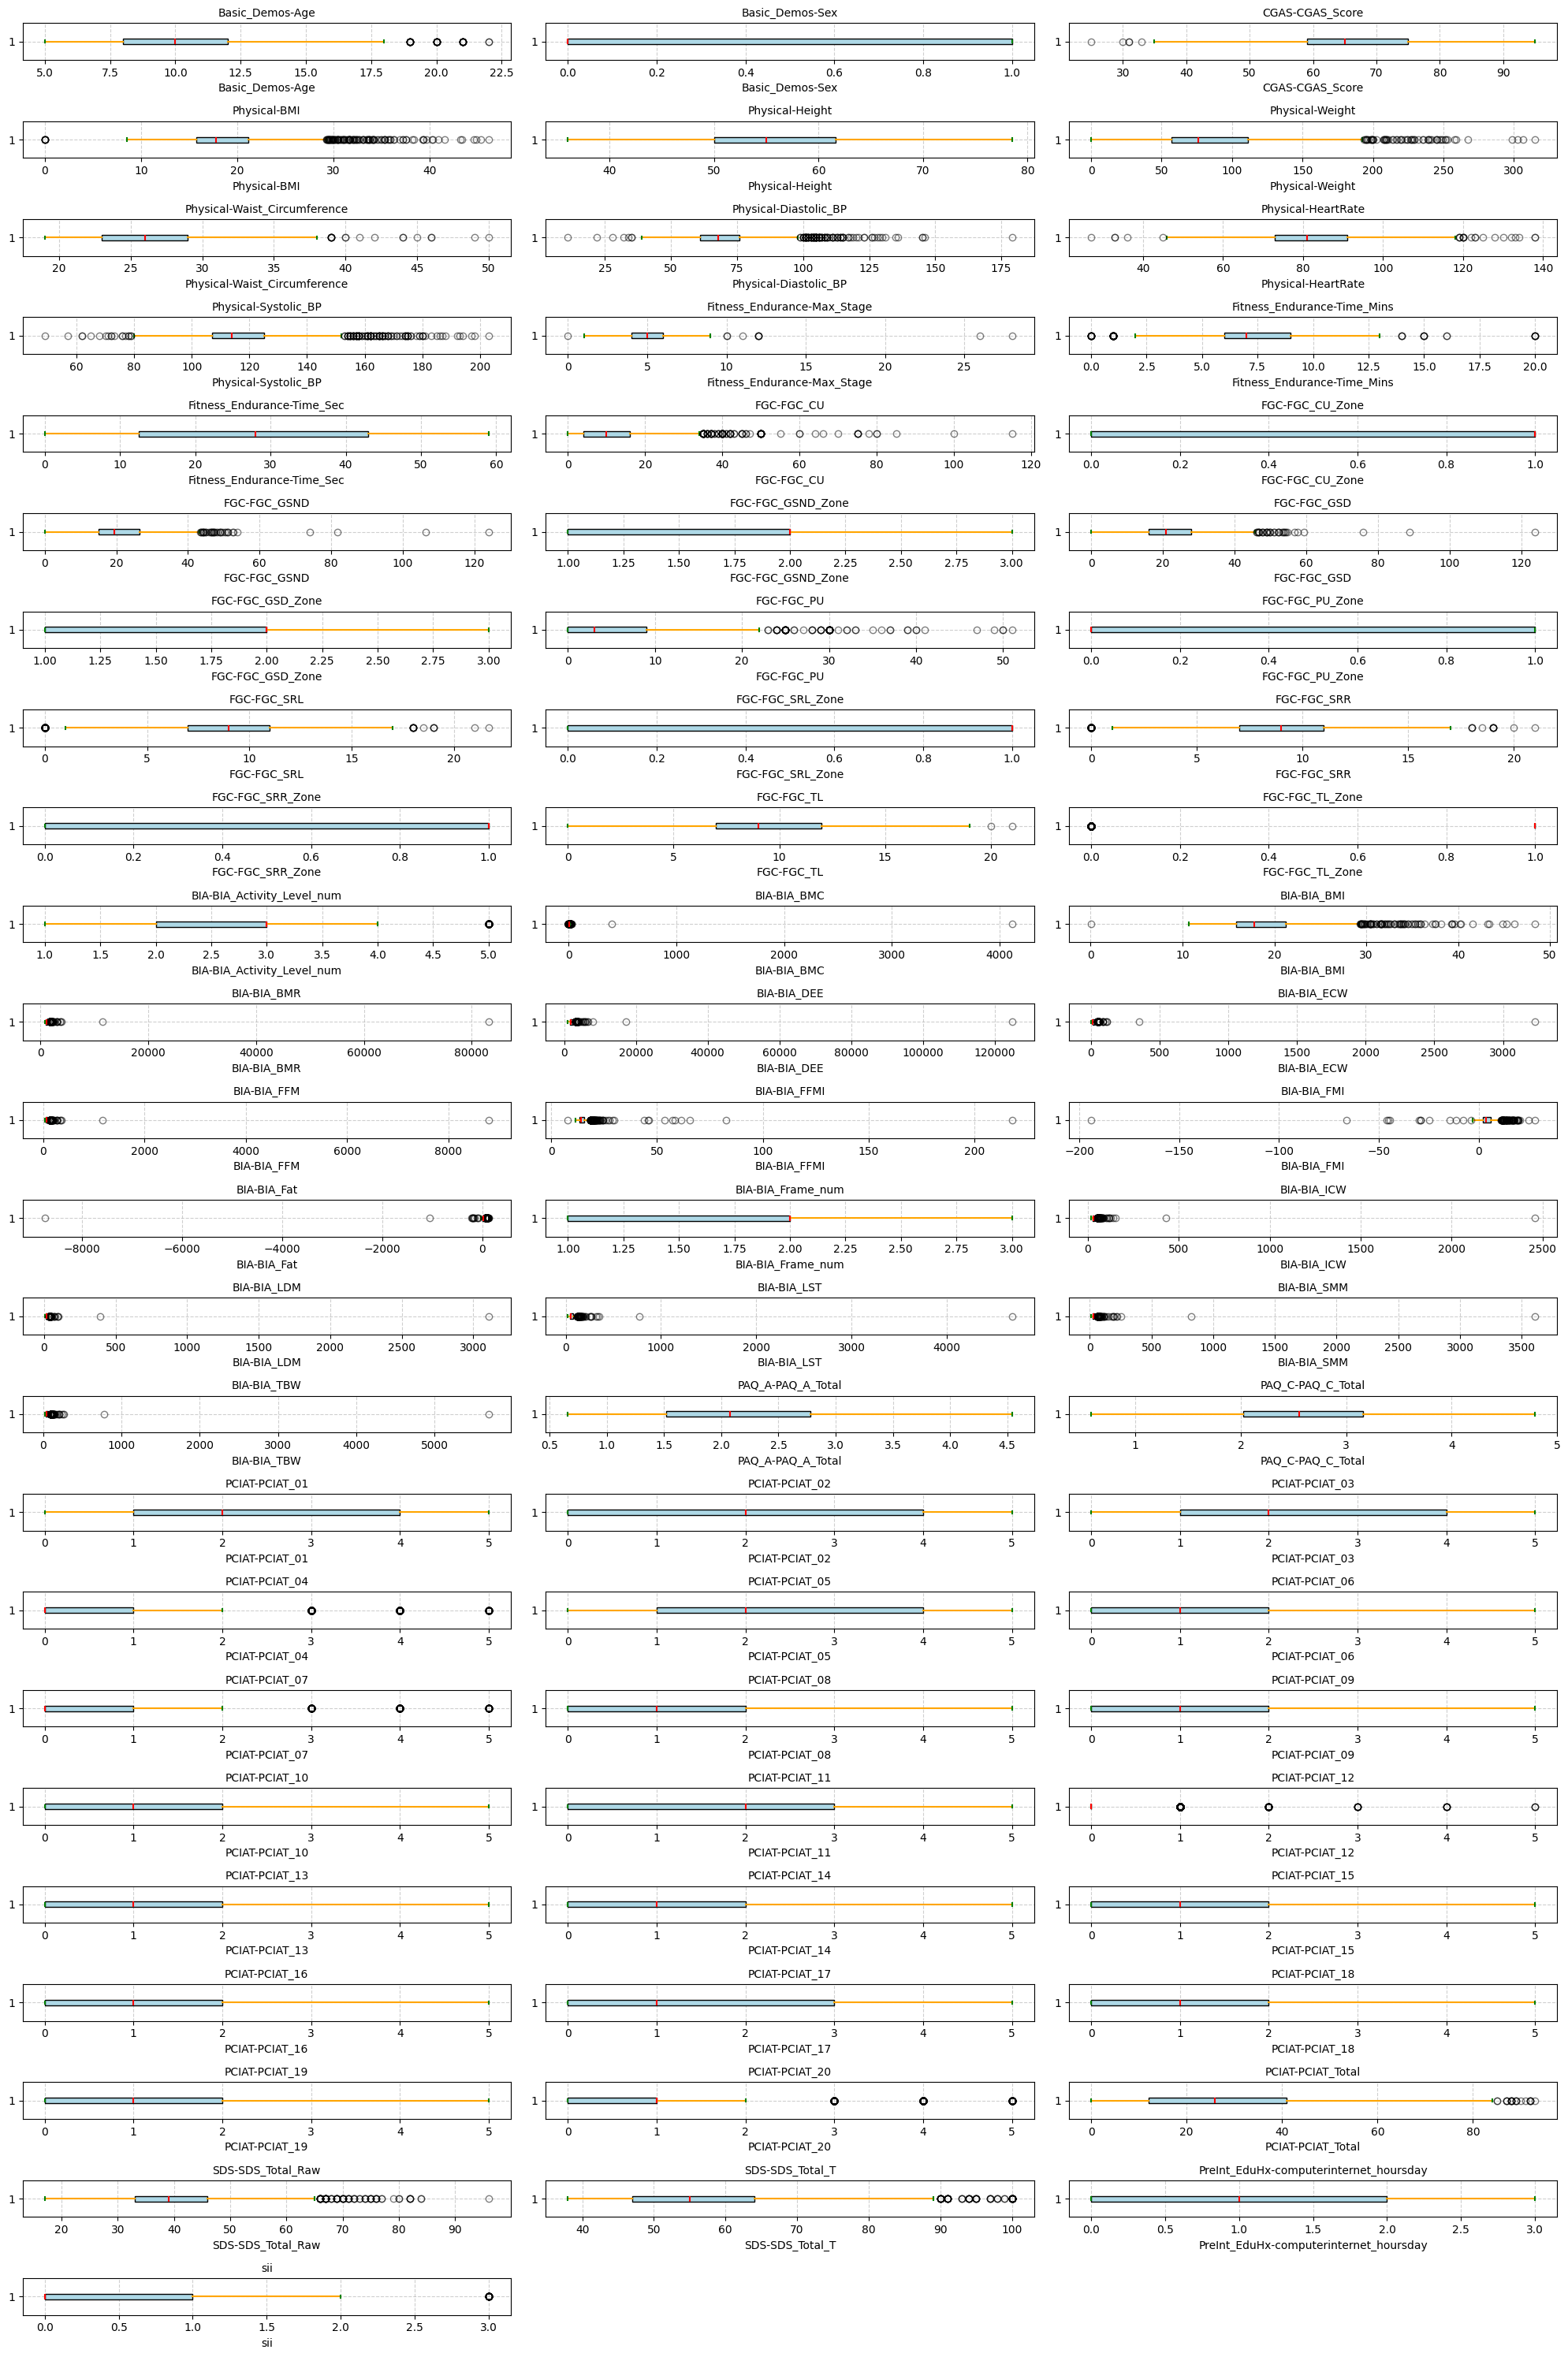

In [18]:
numeric_cols = train.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(20, 30)) 
plt.subplots_adjust(hspace=0.3, wspace=0.3) 
n_cols = 3  
# Grafiklerin her biri için döngü
for idx, col in enumerate(numeric_cols):
    plt.subplot((len(numeric_cols) // n_cols) + 1, n_cols, idx + 1)
    plt.boxplot(train[col].dropna(), vert=False, patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='red', linewidth=1.5),
                whiskerprops=dict(color='orange', linewidth=1.5),
                capprops=dict(color='green', linewidth=1.5),
                flierprops=dict(marker='o', color='purple', alpha=0.5))
    plt.title(f'{col}', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel(col)

plt.tight_layout()
plt.show()


In [19]:
def calculate_summary_statistics(dataframe, columns):
    """
    Belirli sütunlar için istatistiksel özetleri hesaplar.
    
    """
    missing_columns = [col for col in columns if col not in dataframe.columns]
    if missing_columns:
        raise ValueError(f"Veri setinde bulunmayan sütunlar: {missing_columns}")
    

    summary_df = dataframe[columns].describe().transpose()

    summary_df['missing'] = dataframe[columns].isnull().sum()
    
    summary_df = summary_df[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing']]
    
    return summary_df



<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;text-align:center;">
  <h3 style="color:black;margin:0;">Fiziksel Özelliklerin Analizi </h3>
</div>

In [20]:
columns = [
    'Physical-Season',
    'Physical-BMI',
    'Physical-Height',
    'Physical-Weight',
    'Physical-Waist_Circumference',
    'Physical-Diastolic_BP',
    'Physical-HeartRate',
    'Physical-Systolic_BP'
]
calculate_summary_statistics(train, columns)

,count,mean,std,min,25%,50%,75%,max,missing
Physical-BMI,2513.00,19.13,4.91,0.00,15.78,17.82,21.17,46.10,206
Physical-Height,2516.00,55.89,7.39,36.00,50.00,55.00,61.64,78.50,203
Physical-Weight,2557.00,87.86,43.36,0.00,57.20,75.80,111.40,315.00,162
Physical-Waist_Circumference,480.00,26.63,5.23,19.00,23.00,26.00,29.00,50.00,2239
Physical-Diastolic_BP,2464.00,69.78,13.81,11.00,61.00,68.00,76.00,179.00,255
Physical-HeartRate,2472.00,81.84,13.78,27.00,73.00,81.00,91.00,138.00,247
Physical-Systolic_BP,2464.00,117.13,17.24,49.00,107.00,114.00,125.00,203.00,255


<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <h3 style="color:black; text-align:center;">Physical-BMI (Vücut Kitle İndeksi)</h3>
  <ul>
    <li>BMI verisinin sıfır olması anlamsızdır çünkü vücut kitle indeksi (kg/m²) her zaman pozitif bir değer olmalıdır.</li>
  </ul>
  <h3 style="color:black; text-align:center;">Physical-Weight (Ağırlık)</h3>
  <ul>
    <li>Ağırlık verisi lbs (pound) cinsinden verilmiş olabilir. Veriyi kilograma çevirerek analiz etmek daha mantıklı olur.</li>
    <li>1 lbs = 0.45359237 kg</li>
    <li>5-22 yaş arası bir birey için:<br>
        0 lbs (0 kg) ağırlık mantıksızdır. Bu muhtemelen veri giriş hatasıdır.</li>
  </ul>
  <h3 style="color:black; text-align:center;">Physical-HeartRate (Kalp Hızı)</h3>
  <ul>
    <li>Kalp atış hızı, yaş grubuna göre değişiklik gösterir:</li>
    <li>5-22 yaş arası normal kalp atış hızı genellikle 60 ila 100 bpm (beats per minute) arasındadır.</li>
    <li>45 bpm altı bradikardi (düşük kalp hızı), 120 bpm üstü ise taşikardi (yüksek kalp hızı) olarak kabul edilir.</li>
  </ul>
  <h3 style="color:black; text-align:center;">Physical-Systolic_BP (Sistolik Kan Basıncı)</h3>
  <ul>
    <li>Sistolik kan basıncı genellikle yaşa göre değişir.</li>
    <li>5-22 yaş aralığında normal aralıklar:</li>
    <ul>
      <li>Genç çocuklar (5-12 yaş): Ortalama 90-110 mmHg.</li>
      <li>Ergenler (13-18 yaş): Ortalama 110-120 mmHg.</li>
      <li>Genç yetişkinler (18-22 yaş): Ortalama 110-130 mmHg.</li>
    </ul>
    <li>150 mmHg'den büyük değerler genellikle hipertansiyon belirtisi olarak kabul edilir ve aykırı olabilir.</li>
    <li>80 mmHg'den küçük değerler genellikle düşük tansiyon anlamına gelir ve ölçüm hatası olabilir.</li>
  </ul>
  <h3 style="color:black; text-align:center;">Physical-Diastolic_BP (Diyastolik Kan Basıncı)</h3>
  <ul>
    <li>Diyastolik kan basıncı yaşa göre değişiklik gösterir:</li>
    <ul>
      <li>Genç çocuklar (5-12 yaş): Ortalama 60-70 mmHg.</li>
      <li>Ergenler (13-18 yaş): Ortalama 70-80 mmHg.</li>
      <li>Genç yetişkinler (18-22 yaş): Ortalama 70-85 mmHg.</li>
    </ul>
    <li>100 mmHg'ye yakın veya üzeri değerler hipertansiyona işaret edebilir.</li>
    <li>40 mmHg'nin altındaki değerler genellikle ölçüm hatası olabilir.</li>
  </ul>
</div>


In [21]:
def physical_data(dataframe):
    """
    Veriyi temizler, aykırı değerleri çıkarmaz, onları NaN ile işaretler. Gerekli dönüşümleri yapar ve filtreler.
    Eksik değerleri silmez.
    """
    # 1. Physical-BMI
    if 'Physical-BMI' in dataframe.columns:
        dataframe['Physical-BMI'] = np.where(dataframe['Physical-BMI'] > 0, dataframe['Physical-BMI'], np.nan)
    
    # 2. Physical-Weight
    if 'Physical-Weight' in dataframe.columns:
        dataframe['Physical-Weight'] = dataframe['Physical-Weight'] * 0.45359237  # lbs to kg dönüşümü
        dataframe['Physical-Weight'] = np.where(dataframe['Physical-Weight'] > 10, dataframe['Physical-Weight'], np.nan)
    
    # 3. Physical-HeartRate
    if 'Physical-HeartRate' in dataframe.columns:
        dataframe['Physical-HeartRate'] = np.where(dataframe['Physical-HeartRate'] >= 45, dataframe['Physical-HeartRate'], np.nan)
    
    # 4. Physical-Systolic_BP
    if 'Physical-Systolic_BP' in dataframe.columns:
        dataframe['Physical-Systolic_BP'] = np.where(dataframe['Physical-Systolic_BP'] >= 80, dataframe['Physical-Systolic_BP'], np.nan)
    
    # 5. Physical-Diastolic_BP
    if 'Physical-Diastolic_BP' in dataframe.columns:
        dataframe['Physical-Diastolic_BP'] = np.where(dataframe['Physical-Diastolic_BP'] >= 40, dataframe['Physical-Diastolic_BP'], np.nan)
    
    return dataframe


In [22]:
train = physical_data(train)
test = physical_data(test)

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;text-align:center;">
  <h3 style="color:black;margin:0;">BIA Verilerinin Korelasyon Analizi </h3>
</div>

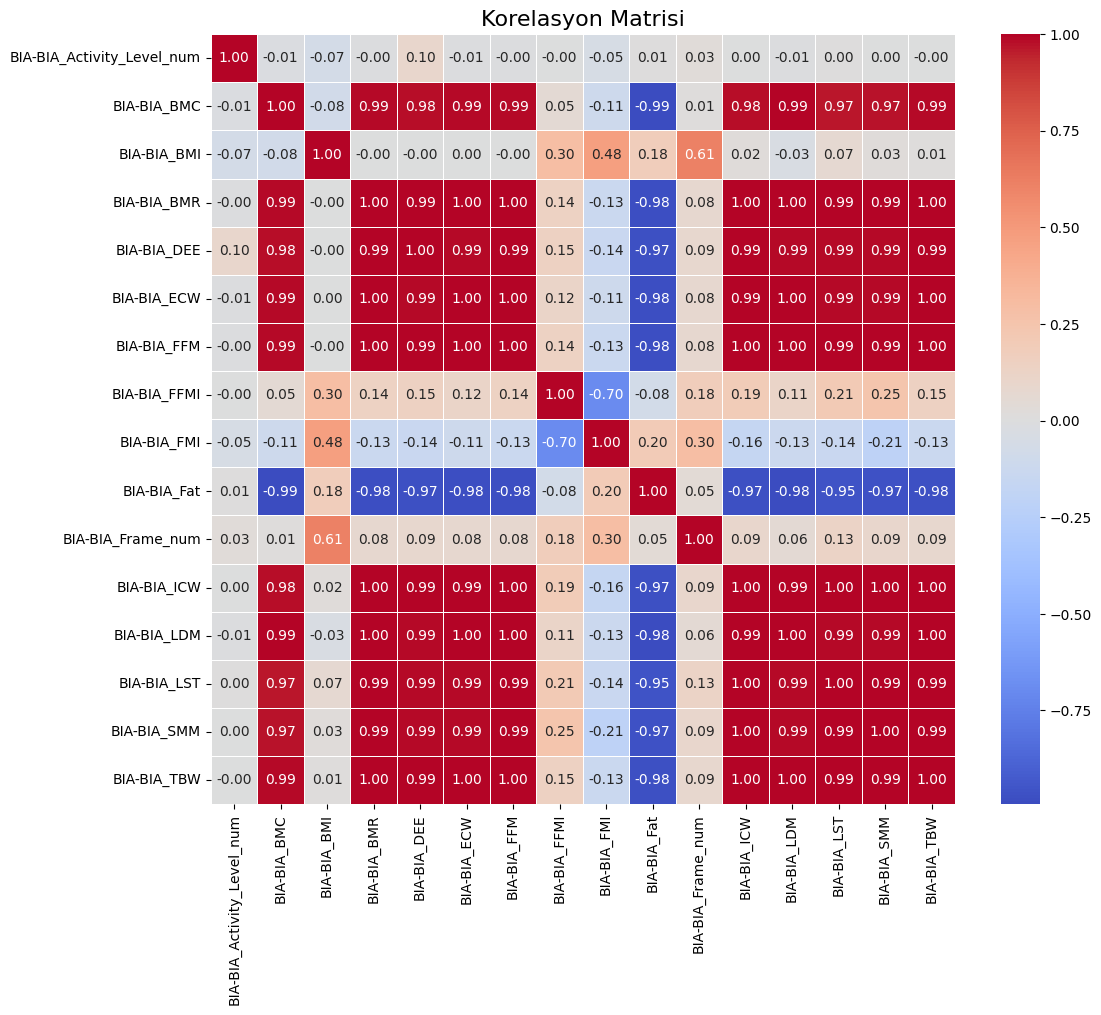

In [23]:
data_columns = [    
    'BIA-BIA_Activity_Level_num',
    'BIA-BIA_BMC',
    'BIA-BIA_BMI',
    'BIA-BIA_BMR',
    'BIA-BIA_DEE',
    'BIA-BIA_ECW',
    'BIA-BIA_FFM',
    'BIA-BIA_FFMI',
    'BIA-BIA_FMI',
    'BIA-BIA_Fat',
    'BIA-BIA_Frame_num',
    'BIA-BIA_ICW',
    'BIA-BIA_LDM',
    'BIA-BIA_LST',
    'BIA-BIA_SMM',
    'BIA-BIA_TBW'
]

filtered_df = train[data_columns]
correlation_matrix = filtered_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korelasyon Matrisi', fontsize=16)
plt.show()


<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;text-align:center;">
  <h3 style="color:black;margin:0;"> Sistolik Kan Basıncı, Diyastolik Kan Basıncından Küçük Olan Kişiler</h3>
  <p style="margin:10px 0;text-align:left;">
    Systolic_BP, Diastolic_BP'den düşük olamaz! Nabız Basıncı hesaplanırken negatif değerlere sebep oluyor.
  </p>

  <h4 style="text-align:left;">1. 14 Yaşındaki Çocuk İçin:</h4>
  <ul style="text-align:left;">
    <li><b>Sistolik Kan Basıncı (Büyük Tansiyon):</b> 110-130 mmHg</li>
    <li><b>Diyastolik Kan Basıncı (Küçük Tansiyon):</b> 70-85 mmHg</li>
  </ul>

  <h4 style="text-align:left;">2. 8 Yaşındaki Çocuk İçin:</h4>
  <ul style="text-align:left;">
    <li><b>Sistolik Kan Basıncı (Büyük Tansiyon):</b> 100-120 mmHg</li>
    <li><b>Diyastolik Kan Basıncı (Küçük Tansiyon):</b> 60-75 mmHg</li>
  </ul>
</div>


In [24]:
filtered_data = train[train['Physical-Systolic_BP'] < train['Physical-Diastolic_BP']]
filtered_data

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
1140,464a75fb,Summer,14,0,Spring,85.00,Fall,25.27,62.00,62.69,NaN,179.00,103.00,139.00,NaN,NaN,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,3.00,3.87,25.28,1312.37,2231.03,13.61,82.05,15.01,10.27,56.15,1.00,33.84,34.60,78.17,53.66,47.45,Fall,2.77,NaN,NaN,Winter,2.00,3.00,3.00,1.00,3.00,2.00,2.00,0.00,1.00,0.00,3.00,0.00,1.00,3.00,3.00,0.00,2.00,0.00,2.00,1.00,32.00,Winter,51.00,71.00,Summer,3.00,1.00
1879,77a5b2ad,Spring,8,1,Summer,80.00,Spring,19.12,53.00,34.65,NaN,117.00,114.00,114.00,Spring,2.00,1.00,59.00,Spring,3.00,0.00,NaN,NaN,NaN,NaN,6.00,1.00,12.00,1.00,12.00,1.00,5.00,0.00,Spring,3.00,6.87,19.12,1068.41,1709.46,17.25,56.06,14.03,5.09,20.34,2.00,25.02,13.80,49.19,23.43,42.26,NaN,NaN,Spring,1.55,Spring,3.00,3.00,2.00,0.00,2.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,2.00,0.00,2.00,1.00,1.00,1.00,1.00,1.00,20.00,Spring,43.00,60.00,Spring,0.00,0.00


In [25]:
filtered_data_test = test[test['Physical-Systolic_BP'] < test['Physical-Diastolic_BP']]
filtered_data_test

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday


In [26]:
train = train[~(train['Physical-Systolic_BP'] < train['Physical-Diastolic_BP'])]

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;text-align:center">
  <h4 style="color:black;margin:0;">Kan Basıncı(Pulse Pressure) = Physical-Systolic_BP - Physical-Diastolic_BP  </h4>
</div>


In [27]:
def calculate_and_add_pulse_pressure(df, systolic_col, diastolic_col, new_col='Pulse_Pressure'):
    """
    Sistolik ve diyastolik kan basıncından Pulse Pressure hesaplar,
    her iki sütun NaN ise sonuç NaN olur.
    """
    # Pulse Pressure hesapla ve NaN değerleri koru
    df[new_col] = df.apply(
        lambda row: row[systolic_col] - row[diastolic_col] 
        if pd.notnull(row[systolic_col]) and pd.notnull(row[diastolic_col]) 
        else np.nan, axis=1
    )
    
    # Kullanılan sütunları kaldır
    df.drop(columns=[systolic_col, diastolic_col], inplace=True)
    
    return df

In [28]:
train = calculate_and_add_pulse_pressure(train, 'Physical-Systolic_BP', 'Physical-Diastolic_BP', new_col='Pulse_Pressure')
test = calculate_and_add_pulse_pressure(test,'Physical-Systolic_BP', 'Physical-Diastolic_BP', new_col='Pulse_Pressure')

# Yeni oluşturulan 'Pulse_Pressure' değişkeninin özet istatistikleri
pulse_pressure_summary = train['Pulse_Pressure'].describe()
pulse_pressure_summary

count   2434.00
mean      47.48
std       12.54
min       13.00
25%       40.00
50%       47.00
75%       54.00
max      131.00
Name: Pulse_Pressure, dtype: float64

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;text-align:center;">
  <h3 style="color:black;margin:0;">BMI Hesaplama </h3>
  <p style="margin:10px 0;text-align:left;">
     BMI , kişinin vücut ağırlığını ve boyunu kullanarak hesaplanan bir metriktir. İki farklı sütunda kişinin Vücut Kitle İndeksi bulunmaktadır. Her iki sütunda da yanlışlıklar olduğu tespit edilmektedir. Bu kıyaslamanın sonucunda bu iki BMI değeri silinmekte olup formül ile hesaplatılan değer kullanılacaktır.
  </p>
  
</div>

In [29]:
def calculate_bmi(weight_lbs, height_in):
    if pd.notnull(weight_lbs) and pd.notnull(height_in):
        weight_kg = weight_lbs * 0.453592  
        height_m = height_in * 0.0254 
        return weight_kg / (height_m ** 2)
    return None

def compare_bmi_and_season_no_addition(df, col1, col2, col3, col4, weight_col, height_col):
    df["Calculated-BMI"] = df.apply(lambda row: calculate_bmi(row[weight_col], row[height_col]), axis=1)
    
    bmi_match = (df["Calculated-BMI"] == df[col1]) | (df["Calculated-BMI"] == df[col2])
    season_match = df[col3] == df[col4]

    comparison_result = df[["Physical-BMI", "BIA-BIA_BMI", "Calculated-BMI", "Physical-Season", "BIA-Season"]]
    comparison_result["BMI_Match"] = bmi_match
    comparison_result["Season_Match"] = season_match
    
    return comparison_result

result = compare_bmi_and_season_no_addition(train, "Physical-BMI", "BIA-BIA_BMI", "Physical-Season", "BIA-Season", "Physical-Weight", "Physical-Height")
result.head()


,Physical-BMI,BIA-BIA_BMI,Calculated-BMI,Physical-Season,BIA-Season,BMI_Match,Season_Match
0,16.88,16.88,7.66,Fall,Fall,False,True
1,14.04,14.04,6.37,Fall,Winter,False,False
2,16.65,NaN,7.55,Fall,NaN,False,False
3,18.29,18.29,8.30,Summer,Summer,False,True
5,22.28,30.19,10.11,Summer,Summer,False,True


In [30]:
def process_bmi(df, weight_col, height_col):
    df["Calculated-BMI"] = df.apply(lambda row: calculate_bmi(row[weight_col], row[height_col]), axis=1)
    
    # Physical-BMI, BIA-BIA_BMI, Physical-Weight ve Physical-Height silindi
    df.drop(columns=["Physical-BMI", "BIA-BIA_BMI", weight_col, height_col], inplace=True)
    
    # Calculated-BMI kalacak sadece
    df = df[["Calculated-BMI"]]
    
    return df

result = process_bmi(train, "Physical-Weight", "Physical-Height")
result1 = process_bmi(test, "Physical-Weight", "Physical-Height")

train.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-Waist_Circumference,Physical-HeartRate,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Pulse_Pressure,Calculated-BMI
0,00008ff9,Fall,5,0,Winter,51.00,Fall,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.00,0.00,NaN,NaN,NaN,NaN,0.00,0.00,7.00,0.00,6.00,0.00,6.00,1.00,Fall,2.00,2.67,932.50,1492.00,8.26,41.59,13.82,3.06,9.21,1.00,24.43,8.90,38.92,19.54,32.69,NaN,NaN,NaN,NaN,Fall,5.00,4.00,4.00,0.00,4.00,0.00,0.00,4.00,0.00,0.00,4.00,0.00,4.00,4.00,4.00,4.00,4.00,4.00,2.00,4.00,55.00,NaN,NaN,NaN,Fall,3.00,2.00,NaN,7.66
1,000fd460,Summer,9,0,NaN,NaN,Fall,22.00,70.00,NaN,NaN,NaN,NaN,Fall,3.00,0.00,NaN,NaN,NaN,NaN,5.00,0.00,11.00,1.00,11.00,1.00,3.00,0.00,Winter,2.00,2.58,936.66,1498.65,6.02,42.03,12.83,1.21,3.97,1.00,21.04,14.97,39.45,15.41,27.06,NaN,NaN,Fall,2.34,Fall,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Fall,46.00,64.00,Summer,0.00,0.00,47.00,6.37
2,00105258,Summer,10,1,Fall,71.00,Fall,NaN,94.00,Fall,5.00,7.00,33.00,Fall,20.00,1.00,10.20,1.00,14.70,2.00,7.00,1.00,10.00,1.00,10.00,1.00,5.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.17,Fall,5.00,2.00,2.00,1.00,2.00,1.00,1.00,2.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,2.00,2.00,1.00,1.00,28.00,Fall,38.00,54.00,Summer,2.00,0.00,52.00,7.55
3,00115b9f,Winter,9,0,Fall,71.00,Summer,NaN,97.00,Summer,6.00,9.00,37.00,Summer,18.00,1.00,NaN,NaN,NaN,NaN,5.00,0.00,7.00,0.00,7.00,0.00,7.00,1.00,Summer,3.00,3.84,1131.43,1923.44,15.59,62.78,14.07,4.22,18.82,2.00,30.40,16.78,58.93,26.48,46.00,NaN,NaN,Winter,2.45,Summer,4.00,2.00,4.00,0.00,5.00,1.00,0.00,3.00,2.00,2.00,3.00,0.00,3.00,0.00,0.00,3.00,4.00,3.00,4.00,1.00,44.00,Summer,31.00,45.00,Winter,0.00,1.00,57.00,8.30
5,001f3379,Spring,13,1,Winter,50.00,Summer,NaN,73.00,NaN,NaN,NaN,NaN,Summer,12.00,0.00,16.50,2.00,17.90,2.00,6.00,0.00,10.00,1.00,11.00,1.00,8.00,0.00,Summer,2.00,4.33,1330.97,1996.45,30.21,84.03,16.69,13.50,67.97,2.00,32.91,20.90,79.70,35.38,63.13,NaN,NaN,Spring,4.11,Summer,3.00,3.00,3.00,0.00,2.00,1.00,0.00,2.00,2.00,1.00,0.00,1.00,3.00,3.00,2.00,1.00,3.00,1.00,2.00,1.00,34.00,Summer,40.00,56.00,Spring,0.00,1.00,42.00,10.11


<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;text-align:center">
  <h4 style="color:black;margin:0;">BIA-BIA_TBW	= BIA-BIA_ICW +	BIA-BIA_ECW	 </h4>
    <p style="margin:10px 0;text-align:left;">
    Bu iki değişkenin toplamı total hesaplanıp BIA-BIA_ECW ile kıyaslandığında TRUE gelmeyen değerler incelenip bu değerlerin virgül hesaplamalarından dolayı küçük farklarla(genelde 0.1) false geldiği kanısına varılmaktadır. BIA-BIA_TBW ve BIA-BIA_ICW değerlerinin hedef değişkenle doğrudan bir ilişkisinin olmaması ve modele doğrudan bir katkısnın olmadığı saptanmaktadır. Model karmaşıklığını azaltmak adına bu iki değer silinmektedir. Bunların toplamını veren BIA-BIA_TBW veri setinde gerekli bilgiyi sağlamaktadır.
  </p>
</div>


In [31]:
def check_total_body_water_valid_and_count_with_nan(df):
    valid_rows = df.dropna(subset=["BIA-BIA_TBW", "BIA-BIA_ICW", "BIA-BIA_ECW"])

    icw = valid_rows["BIA-BIA_ICW"].round(2)
    ecw = valid_rows["BIA-BIA_ECW"].round(2)
    tbw = valid_rows["BIA-BIA_TBW"].round(2)
    
    valid_rows["Total_Water_Match"] = (icw + ecw == tbw)
    
    true_count = valid_rows["Total_Water_Match"].sum() 
    false_count = len(valid_rows) - true_count  
    
    nan_count = len(df) - len(valid_rows)
    
    return valid_rows[["BIA-BIA_TBW", "BIA-BIA_ICW", "BIA-BIA_ECW", "Total_Water_Match"]], true_count, false_count, nan_count

result_check_tbw_valid, true_count, false_count, nan_count = check_total_body_water_valid_and_count_with_nan(train)

result_check_tbw_valid.head()


,BIA-BIA_TBW,BIA-BIA_ICW,BIA-BIA_ECW,Total_Water_Match
0,32.69,24.43,8.26,True
1,27.06,21.04,6.02,True
3,46.00,30.40,15.59,False
5,63.13,32.91,30.21,False
6,47.22,30.89,16.33,True


In [32]:
columns_to_drop = ["BIA-BIA_ICW", "BIA-BIA_ECW"]

train = train.drop(columns=columns_to_drop)
test = test.drop(columns=columns_to_drop)

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;text-align:center">
  <h4 style="color:black;margin:0;"> PAQ_A-PAQ_A_Total ve PAQ_C-PAQ_C_Total Sütunlarının Analizi </h4>
    <p style="margin:10px 0;text-align:left;">
Eksik verilere sahip olan sütunlar incelendiğinde PAQ_A-PAQ_A_Total ve PAQ_C-PAQ_C_Total Değişkenlerden biri çocukları diğeri ergenlerin Toplam Faaliyet Özet Puanını içermektedir.  Birbirini tamamlayan bu değişkenler tek sütunda toplanmaktadır.
  </p>
</div>


In [33]:
selected_columns = [
    'PAQ_A-Season',
    'PAQ_A-PAQ_A_Total',
    'PAQ_C-Season',
    'PAQ_C-PAQ_C_Total',
    'Basic_Demos-Age'
]

comparison_df_clean = train[selected_columns]
comparison_df_clean

,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,Basic_Demos-Age
0,NaN,NaN,NaN,NaN,5
1,NaN,NaN,Fall,2.34,9
2,NaN,NaN,Summer,2.17,10
3,NaN,NaN,Winter,2.45,9
5,NaN,NaN,Spring,4.11,13
...,...,...,...,...,...
3953,NaN,NaN,Fall,3.44,8
3954,NaN,NaN,NaN,NaN,7
3955,NaN,NaN,Winter,3.26,13
3957,NaN,NaN,Winter,2.73,11


<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:left;">
    Eksik verilere sahip olan sütunlar incelendiğinde, PAQ_A-PAQ_A_Total ve PAQ_C-PAQ_C_Total değişkenlerinden her ikisi de NaN olarak belirlenen sadece bir kişi bulunmaktadır. 
    Bu da genel çıkarımımızın doğru olduğunu bizlere göstermektedir.
  </p>
</div>


In [34]:
filtered_df = train.dropna(subset=['PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total'])
filtered_df_test = test.dropna(subset=['PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total'])

selected_columns = [
    'PAQ_A-Season',
    'PAQ_A-PAQ_A_Total',
    'PAQ_C-Season',
    'PAQ_C-PAQ_C_Total',
    'Basic_Demos-Age'
]

comparison_df_clean1 = filtered_df[selected_columns]
comparison_df_clean2 = filtered_df_test[selected_columns]

comparison_df_clean1

,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,Basic_Demos-Age
3331,Summer,2.27,Spring,2.32,13


<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:left;font-family:Arial, sans-serif;font-size:14px;">
    PAQ_A ve PAQ_C skorlarını tek bir sütuna birleştirir:<br>
    - İkisi de mevcutsa ortalamasını alır.<br>
    - Sadece biri varsa onu kullanır.<br>
    - Her ikisi de yoksa NaN olarak bırakır.<br>
  </p>
  <p style="margin:10px 0;text-align:left;font-family:Arial, sans-serif;font-size:14px;">
    Ayrıca ilgili sezon bilgisini de ekler:<br>
    - Hangisinin toplam skoru kullanıldıysa onun sezonunu ekler.<br>
    - İkisi de varsa PAQ_C-Season önceliklidir.<br>
  </p>
  <p style="margin:10px 0;text-align:left;font-family:Arial, sans-serif;font-size:14px;">
    Son olarak, kullanılan sütunları siler.
  </p>
</div>

In [35]:
def combine_paq_scores(data):
    data['PAQ_PAQ_Total'] = data.apply(
        lambda row: (row['PAQ_A-PAQ_A_Total'] + row['PAQ_C-PAQ_C_Total']) / 2 
        if pd.notnull(row['PAQ_A-PAQ_A_Total']) and pd.notnull(row['PAQ_C-PAQ_C_Total']) else
        row['PAQ_A-PAQ_A_Total'] if pd.notnull(row['PAQ_A-PAQ_A_Total']) else 
        row['PAQ_C-PAQ_C_Total'] if pd.notnull(row['PAQ_C-PAQ_C_Total']) else np.nan, 
        axis=1
    )
    
    data['PAQ_Season'] = data.apply(
        lambda row: row['PAQ_C-Season'] if pd.notnull(row['PAQ_C-PAQ_C_Total']) else
        row['PAQ_A-Season'] if pd.notnull(row['PAQ_A-PAQ_A_Total']) else np.nan,
        axis=1
    )
    
    columns_to_drop = ['PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total']
    data.drop(columns=columns_to_drop, inplace=True)
    
    return data

train = combine_paq_scores(train)
test = combine_paq_scores(test)
train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-Waist_Circumference,Physical-HeartRate,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Pulse_Pressure,Calculated-BMI,PAQ_PAQ_Total,PAQ_Season
0,00008ff9,Fall,5,0,Winter,51.00,Fall,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.00,0.00,NaN,NaN,NaN,NaN,0.00,0.00,7.00,0.00,6.00,0.00,6.00,1.00,Fall,2.00,2.67,932.50,1492.00,41.59,13.82,3.06,9.21,1.00,8.90,38.92,19.54,32.69,Fall,5.00,4.00,4.00,0.00,4.00,0.00,0.00,4.00,0.00,0.00,4.00,0.00,4.00,4.00,4.00,4.00,4.00,4.00,2.00,4.00,55.00,NaN,NaN,NaN,Fall,3.00,2.00,NaN,7.66,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,22.00,70.00,NaN,NaN,NaN,NaN,Fall,3.00,0.00,NaN,NaN,NaN,NaN,5.00,0.00,11.00,1.00,11.00,1.00,3.00,0.00,Winter,2.00,2.58,936.66,1498.65,42.03,12.83,1.21,3.97,1.00,14.97,39.45,15.41,27.06,Fall,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Fall,46.00,64.00,Summer,0.00,0.00,47.00,6.37,2.34,Fall
2,00105258,Summer,10,1,Fall,71.00,Fall,NaN,94.00,Fall,5.00,7.00,33.00,Fall,20.00,1.00,10.20,1.00,14.70,2.00,7.00,1.00,10.00,1.00,10.00,1.00,5.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,5.00,2.00,2.00,1.00,2.00,1.00,1.00,2.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,2.00,2.00,1.00,1.00,28.00,Fall,38.00,54.00,Summer,2.00,0.00,52.00,7.55,2.17,Summer
3,00115b9f,Winter,9,0,Fall,71.00,Summer,NaN,97.00,Summer,6.00,9.00,37.00,Summer,18.00,1.00,NaN,NaN,NaN,NaN,5.00,0.00,7.00,0.00,7.00,0.00,7.00,1.00,Summer,3.00,3.84,1131.43,1923.44,62.78,14.07,4.22,18.82,2.00,16.78,58.93,26.48,46.00,Summer,4.00,2.00,4.00,0.00,5.00,1.00,0.00,3.00,2.00,2.00,3.00,0.00,3.00,0.00,0.00,3.00,4.00,3.00,4.00,1.00,44.00,Summer,31.00,45.00,Winter,0.00,1.00,57.00,8.30,2.45,Winter
5,001f3379,Spring,13,1,Winter,50.00,Summer,NaN,73.00,NaN,NaN,NaN,NaN,Summer,12.00,0.00,16.50,2.00,17.90,2.00,6.00,0.00,10.00,1.00,11.00,1.00,8.00,0.00,Summer,2.00,4.33,1330.97,1996.45,84.03,16.69,13.50,67.97,2.00,20.90,79.70,35.38,63.13,Summer,3.00,3.00,3.00,0.00,2.00,1.00,0.00,2.00,2.00,1.00,0.00,1.00,3.00,3.00,2.00,1.00,3.00,1.00,2.00,1.00,34.00,Summer,40.00,56.00,Spring,0.00,1.00,42.00,10.11,4.11,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,ff6c2bb8,Fall,8,0,NaN,NaN,Fall,25.00,65.00,NaN,NaN,NaN,NaN,Fall,0.00,0.00,NaN,NaN,NaN,NaN,0.00,0.00,8.00,1.00,10.00,1.00,12.00,1.00,Fall,3.00,3.20,1035.27,1759.96,52.53,13.40,3.74,14.67,1.00,15.81,49.33,20.26,36.72,Fall,3.00,3.00,3.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,3.00,0.00,2.00,2.00,1.00,22.00,Fall,41.00,58.00,Fall,2.00,0.00,52.00,7.78,3.44,Fall
3954,ff759544,Summer,7,1,NaN,NaN,Summer,23.00,75.00,NaN,NaN,NaN,NaN,Summer,0.00,0.00,NaN,NaN,NaN,NaN,0.00,0.00,9.00,0.00,8.50,0.00,4.50,0.00,Fall,1.00,2.37,966.29,1256.17,45.19,13.23,0.41,1.41,1.00,15.14,42.82,18.09,30.05

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;text-align:center">
  <h3 style="color:black;margin:0;"> Uyku Bozukluğu, İnternet Kullanım Saati ve SII İlişkisinin İncelenmesi  </h3>
</div>


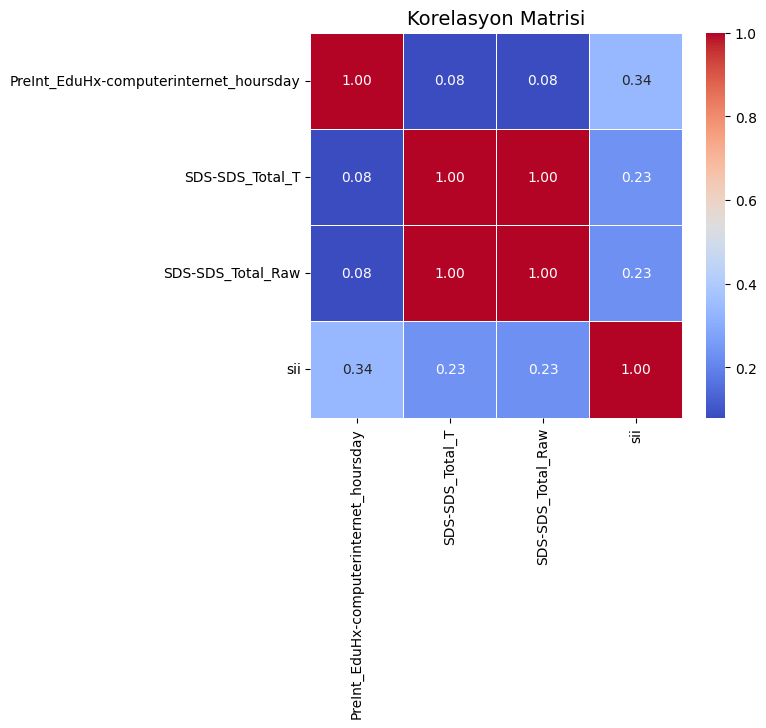

In [36]:
data_columns = [
    'PreInt_EduHx-computerinternet_hoursday',
    'SDS-SDS_Total_T',
    'SDS-SDS_Total_Raw',
    'sii'
]
filtered_df = train[data_columns]
correlation_matrix = filtered_df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korelasyon Matrisi', fontsize=14)
plt.show()

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:center;">
SDS-SDS_Total_Raw değerinin standartlaştırılmış hali SDS-SDS_Total_T değeridir. Bu yüzden SDS-SDS_Total_T değerini baz alındı diğeri silindi.
  </p>
</div>


In [37]:
train.drop(train[['SDS-SDS_Total_Raw']],axis=1,inplace=True)
test.drop(test[['SDS-SDS_Total_Raw']],axis=1,inplace=True)

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:left;">
Analiz sonuçlarına göre, SDS-SDS_Total_T ile sii ve PreInt_EduHx-computerinternet_hoursday arasında genel olarak doğrusal bir ilişki gözlemlenmiştir. Bilgisayar/internet kullanım süresi arttıkça SDS-SDS_Total_T skorları genelde yükselme eğilimindedir. Ancak, bu doğrusal ilişkiyi bozan bazı istisnai durumlar da tespit edilmiştir.

SDS-SDS_Total_T değerleri, daha iyi analiz edilebilmesi için sleep_category adıyla kategorize edilmiştir:

- Düşük (0-50): Düşük skor
- Orta (50-60): Orta skor
- Yüksek (60-70): Yüksek skor
- Çok Yüksek (70-101): Çok yüksek skor

Bu kategoriler, Label Encoding yöntemiyle sayısal değerlere dönüştürülmüş ve sii ile ilişkisi incelenmiştir. İstisnai durumlar, verideki özel durumlar olarak değerlendirilmiş ve rapora dahil edilmiştir.
  </p>
</div>


In [38]:
train.groupby(['sii'])['SDS-SDS_Total_T'].mean()

sii
0.00   55.42
1.00   59.21
2.00   63.05
3.00   69.77
Name: SDS-SDS_Total_T, dtype: float64

In [39]:
train.groupby(['sii','PreInt_EduHx-computerinternet_hoursday']).agg({'SDS-SDS_Total_T' : 'mean'})

SDS-SDS_Total_T
sii  PreInt_EduHx-computerinternet_hoursday                 
0.00 0.00                                              55.28
     1.00                                              55.49
     2.00                                              55.47
     3.00                                              58.17
1.00 0.00                                              59.37
     1.00                                              59.69
     2.00                                              59.71
     3.00                                              56.43
2.00 0.00                                              63.72
     1.00                                              62.57
     2.00                                              63.45
     3.00                                              62.84
3.00 0.00                                              65.00
     1.00                                              64.00
     2.00                                              70.50
     3.00                                              71.92

In [40]:
le = LabelEncoder()

In [41]:
train['sleep_category'] = pd.cut(train['SDS-SDS_Total_T'], bins=[0, 50, 60, 70, 101], labels=['Düşük', 'Orta', 'Yüksek', 'Çok Yüksek'],right=False)
train['sleep_category'] = le.fit_transform(train['sleep_category'])

In [42]:
test['sleep_category'] = pd.cut(test['SDS-SDS_Total_T'], bins=[0, 50, 60, 70, 101], labels=['Düşük', 'Orta', 'Yüksek', 'Çok Yüksek'],right=False)
test['sleep_category'] = le.fit_transform(test['sleep_category'])

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:center;">
Sütunlarda 0.70 ten fazla NaN değer varsa bu sütunlar silinmektedir.
  </p>
</div>


In [43]:
threshold = 0.70 * len(train.columns)

train = train.dropna(thresh=int(len(train.columns) - threshold))
train.shape

(2717, 74)

In [44]:
# Test setinde eksik sütunları bul
missing_cols_in_test = set(train.columns) - set(test.columns)
print(f"Test setinde eksik sütunlar: {missing_cols_in_test}")


Test setinde eksik sütunlar: {'PCIAT-PCIAT_11', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_Total', 'PCIAT-PCIAT_15', 'sii', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_14', 'PCIAT-Season', 'PCIAT-PCIAT_20'}


<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:center;">
Sezon Sütunlarının genel olarak modele bir katkısı olmadığı tespit edildiği için silindi.
  </p>
</div>


In [45]:
season_cols = [col for col in train.columns if 'Season' in col]
train.drop(season_cols, axis=1, inplace=True)

season_cols = [col for col in test.columns if 'Season' in col]
test.drop(season_cols, axis=1, inplace=True)

In [46]:
train.head()

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-HeartRate,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,Pulse_Pressure,Calculated-BMI,PAQ_PAQ_Total,sleep_category
0,00008ff9,5,0,51.00,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,0.00,0.00,7.00,0.00,6.00,0.00,6.00,1.00,2.00,2.67,932.50,1492.00,41.59,13.82,3.06,9.21,1.00,8.90,38.92,19.54,32.69,5.00,4.00,4.00,0.00,4.00,0.00,0.00,4.00,0.00,0.00,4.00,0.00,4.00,4.00,4.00,4.00,4.00,4.00,2.00,4.00,55.00,NaN,3.00,2.00,NaN,7.66,NaN,4
1,000fd460,9,0,NaN,22.00,70.00,NaN,NaN,NaN,3.00,0.00,NaN,NaN,NaN,NaN,5.00,0.00,11.00,1.00,11.00,1.00,3.00,0.00,2.00,2.58,936.66,1498.65,42.03,12.83,1.21,3.97,1.00,14.97,39.45,15.41,27.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,64.00,0.00,0.00,47.00,6.37,2.34,2
2,00105258,10,1,71.00,NaN,94.00,5.00,7.00,33.00,20.00,1.00,10.20,1.00,14.70,2.00,7.00,1.00,10.00,1.00,10.00,1.00,5.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00,2.00,2.00,1.00,2.00,1.00,1.00,2.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,2.00,2.00,1.00,1.00,28.00,54.00,2.00,0.00,52.00,7.55,2.17,1
3,00115b9f,9,0,71.00,NaN,97.00,6.00,9.00,37.00,18.00,1.00,NaN,NaN,NaN,NaN,5.00,0.00,7.00,0.00,7.00,0.00,7.00,1.00,3.00,3.84,1131.43,1923.44,62.78,14.07,4.22,18.82,2.00,16.78,58.93,26.48,46.00,4.00,2.00,4.00,0.00,5.00,1.00,0.00,3.00,2.00,2.00,3.00,0.00,3.00,0.00,0.00,3.00,4.00,3.00,4.00,1.00,44.00,45.00,0.00,1.00,57.00,8.30,2.45,0
5,001f3379,13,1,50.00,NaN,73.00,NaN,NaN,NaN,12.00,0.00,16.50,2.00,17.90,2.00,6.00,0.00,10.00,1.00,11.00,1.00,8.00,0.00,2.00,4.33,1330.97,1996.45,84.03,16.69,13.50,67.97,2.00,20.90,79.70,35.38,63.13,3.00,3.00,3.00,0.00,2.00,1.00,0.00,2.00,2.00,1.00,0.00,1.00,3.00,3.00,2.00,1.00,3.00,1.00,2.00,1.00,34.00,56.00,0.00,1.00,42.00,10.11,4.11,1


# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 Zaman Serisi Analizi</span>

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:center;">
Bu notebook üzerinde ayrı ayrı lstm ve prophet ile özellik çıkarımı yaptığımızda lstm private skorda 0.480, prophet ise 0.476 verdiği için lstm kullanarak zaman serisinde özellik çıkarımı gerçekleştirildi.
  </p>
</div>

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;text-align:center;">
 <h4 style="color:black;margin:0;"> LSTM Model ve Özellik Çıkarma Süreci </h4>
  <p style="margin:10px 0;text-align:center;">
Bu mimari, bir LSTM modeli kullanarak özellik çıkarma işlemini detaylandırmaktadır. Süreç, veri hazırlama, LSTM modeliyle işleme ve özelliklerin çıkarılması adımlarından oluşur. Model çağrıldığında LSTM katmanı girdiyi işler ve sıralı veriden zaman içindeki ilişkileri öğrenir.
LSTM çıkışı, nn.Linear katmanına aktarılır. Bu katman, LSTM'nin öğrenilmiş temsillerini (gizli durumları yani hidden state) son boyuta indirger ve sabit uzunlukta bir çıktı oluşturur.
  </p>
</div>



```plaintext
+-----------------------------------------------+
|                  Girdi: df                    |
+-----------------------------------------------+
                     |
                     v
        +---------------------------+
        |  Eksik Değerlerin Doldurulması  |
        +---------------------------+
                     |
                     v
        +---------------------------+
        |   Verinin Ölçeklendirilmesi   |
        +---------------------------+
                     |
                     v
        +---------------------------+
        |  Tensor Formatına Dönüşüm  |
        +---------------------------+
                     |
                     v
+-----------------------------------------------+
|               LSTM Modeli (model)             |
|  +-----------------------------------------+  |
|  |  nn.LSTM -> nn.Linear (fc)              |  |
|  +-----------------------------------------+  |
+-----------------------------------------------+
                     |
                     v
        +---------------------------+
        | Özelliklerin Çıkarılması  |
        +---------------------------+
                     |
                     v
        +---------------------------+
        |     Özellikler (features) |   
        +---------------------------+


In [47]:
# ---------------- LSTM Model ----------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])  # Final hidden state
        return out
        
# ---------------- LSTM Özellik Çıkarımı ----------------
def process_parquet_file(parquet_file_path):
    try:
        df = pl.read_parquet(parquet_file_path)
        df = df.filter(pl.col('non-wear_flag') == 0)
        df = df.drop(['X', 'Y', 'Z'])
        return df
    except Exception as e:
        print(f"Hata: {parquet_file_path} işlenemedi. Hata: {e}")
        return None


def extract_features_with_lstm(df, model):
    try:
        df = df.fill_null(0)  # Eksik değerleri doldur
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df.to_pandas())  # Polars -> Pandas

        scaled_data = torch.FloatTensor(scaled_data).unsqueeze(0)  # LSTM için Tensor'a dönüştür
        model.eval()
        with torch.no_grad():
            features = model(scaled_data)

        return features.numpy().flatten()
    except Exception as e:
        print(f"Hata: Özellik çıkarma işlemi başarısız. Hata: {e}")
        return None


def process_and_extract_features(base_path, train_df):
    feature_list = []
    progress_bar = tqdm(os.listdir(base_path), desc="Processing folders", unit="folder")

    for folder in progress_bar:
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path) and folder.startswith("id="):
            id_value = folder.split("=")[1]
            parquet_file_path = os.path.join(folder_path, 'part-0.parquet')

            if os.path.exists(parquet_file_path) and id_value in train_df['id'].values:
                df = process_parquet_file(parquet_file_path)
                if df is not None:
                    model = LSTMModel(input_dim=df.shape[1], hidden_dim=50, output_dim=10)
                    features = extract_features_with_lstm(df, model)
                    if features is not None:
                        feature_list.append((id_value, features))

    progress_bar.close()

    features_df = pd.DataFrame(
        [feat[1] for feat in feature_list],
        columns=[f"lstm_feature_{i+1}" for i in range(10)]
    )
    features_df['id'] = [feat[0] for feat in feature_list]
    return features_df

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:left;">
Dereceye giren birinci kişi tarafından uygulanan zaman serisi veri setinde, özellik çıkarımı işlemi sırasında gündüz (07:00-20:00) ve gece (22:00-05:00) verileri ayrı ayrı incelenmiştir. Aktigraf verilerinden temel istatistiksel özellikler çıkarılmak suretiyle bu iki zaman dilimi için analizler yapılmıştır.
Ayrıca, non-wear_flag değişkeni için de mean (ortalama) değeri alınarak eklenmiştir. Bunun sebebi, bu değişkenin yalnızca 0 ve 1 değerlerinden ibaret olmayıp, farklı değerler de içermesidir. Bu durumu göz önünde bulundurarak, biz de bu eklemeleri çalışmamıza ekledik
  </p>
    <p style="margin:10px 0;text-align:left;">
        - enmo, anglez, battery_voltage istatistikleri: Gündüz ve gece için enmo, anglez, battery_voltage verilerinin ortalama, standart sapma, minimum ve maksimum değerleri.   
  </p>
  <p style="margin:10px 0;text-align:left;">  
        - non-wear_flag: non-wear_flag için ortalama değer.
  </p>

</div>

In [48]:
# ---------------- Zaman Serisi Özellik Çıkarımı ----------------
def extract_time_series_features(df):
    features = []

    df["hours"] = df["time_of_day"] // (3_600 * 1_000_000_000)
    night = ((df["hours"] >= 22) | (df["hours"] <= 5))
    day = ((df["hours"] >= 7) & (df["hours"] <= 20))

    for col in ['battery_voltage', 'enmo', 'anglez']:
        features.extend([
            df.loc[day, col].mean(),
            df.loc[day, col].std(),
            df.loc[day, col].min(),
            df.loc[day, col].max(),
            df.loc[night, col].mean(),
            df.loc[night, col].std(),
            df.loc[night, col].min(),
            df.loc[night, col].max(),
        ])
    features.append(df["non-wear_flag"].mean())  
    features.extend([
        df.loc[day, 'light'].mean(),
        df.loc[night, 'light'].mean(),
    ])

    return features


In [49]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return extract_time_series_features(df), filename.split('=')[1]


def load_time_series(dirname):
    ids = os.listdir(dirname)

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))

    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

In [50]:
# ---------------- Özelliklerin Birleştirilmesi ----------------
def combine_features(base_path, train_df):
    print("Zaman serisi özelliklerini çıkarıyor...")
    time_series_features_df = load_time_series(base_path)

    print("LSTM özelliklerini çıkarıyor...")
    lstm_features_df = process_and_extract_features(base_path, train_df)

    print("Özellikleri birleştiriyor...")
    combined_df = pd.merge(time_series_features_df, lstm_features_df, on='id', how='inner')
    return combined_df

In [51]:
train_combined_features = combine_features(train_ts, train)  
test_combined_features = combine_features(test_ts, test)

Zaman serisi özelliklerini çıkarıyor...


100%|██████████| 996/996 [01:20<00:00, 12.44it/s]


LSTM özelliklerini çıkarıyor...


Processing folders: 100%|██████████| 996/996 [17:57<00:00,  1.08s/folder]


Özellikleri birleştiriyor...
Zaman serisi özelliklerini çıkarıyor...


100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


LSTM özelliklerini çıkarıyor...


Processing folders: 100%|██████████| 2/2 [00:01<00:00,  1.72folder/s]

Özellikleri birleştiriyor...


In [52]:
train = pd.merge(train, train_combined_features, on="id", how="left")
test = pd.merge(test, test_combined_features, on="id", how="left")

In [72]:
train.head()

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-HeartRate,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,Pulse_Pressure,Calculated-BMI,PAQ_PAQ_Total,sleep_category,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,lstm_feature_1,lstm_feature_2,lstm_feature_3,lstm_feature_4,lstm_feature_5,lstm_feature_6,lstm_feature_7,lstm_feature_8,lstm_feature_9,lstm_feature_10
0,00008ff9,5,0,51.00,23.25,85.90,4.46,6.32,29.07,0.00,0.00,5.51,1.74,2.48,1.68,0.00,0.00,7.00,0.00,6.00,0.00,6.00,1.00,2.00,2.67,932.50,1492.00,41.59,13.82,3.06,9.21,1.00,8.90,38.92,19.54,32.69,5.00,4.00,4.00,0.00,4.00,0.00,0.00,4.00,0.00,0.00,4.00,0.00,4.00,4.00,4.00,4.00,4.00,4.00,2.00,4.00,55.00,88.68,3.00,2.00,42.27,7.66,2.46,4,3890.08,139.54,3398.69,4178.86,3879.32,137.11,3507.34,4145.02,0.07,0.16,0.00,4.35,0.02,0.04,0.00,1.30,-8.40,38.43,-89.56,89.04,-7.44,46.70,-88.09,86.92,0.11,54.06,12.04,-0.00,-0.02,-0.01,0.01,0.01,-0.00,0.01,-0.01,-0.00,-0.00
1,000fd460,9,0,62.11,22.00,70.00,5.35,7.85,29.04,3.00,0.00,12.92,1.65,12.67,1.67,5.00,0.00,11.00,1.00,11.00,1.00,3.00,0.00,2.00,2.58,936.66,1498.65,42.03,12.83,1.21,3.97,1.00,14.97,39.45,15.41,27.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,64.00,0.00,0.00,47.00,6.37,2.34,2,3880.62,145.20,3379.90,4178.86,3874.15,141.34,3450.90,4145.03,0.06,0.13,0.00,3.98,0.01,0.03,0.00,1.34,-8.27,38.44,-89.56,89.09,-8.69,46.69,-88.09,86.89,0.16,50.97,12.05,-0.00,-0.02,-0.01,0.00,0.01,-0.00,0.01,-0.01,-0.00,-0.00
2,00105258,10,1,71.00,26.10,94.00,5.00,7.00,33.00,20.00,1.00,10.20,1.00,14.70,2.00,7.00,1.00,10.00,1.00,10.00,1.00,5.00,0.00,2.46,6.96,1264.07,2103.60,76.90,14.15,2.71,2.40,1.52,20.37,65.64,34.46,55.67,5.00,2.00,2.00,1.00,2.00,1.00,1.00,2.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,2.00,2.00,1.00,1.00,28.00,54.00,2.00,0.00,52.00,7.55,2.17,1,3866.11,148.89,3269.84,4178.86,3873.98,142.90,3418.11,4145.19,0.04,0.11,0.00,3.54,0.01,0.02,0.00,1.19,-11.84,39.36,-89.56,88.67,-13.78,45.79,-87.98,84.76,0.29,52.34,12.98,-0.00,-0.01,-0.01,0.00,0.00,-0.01,0.00,-0.01,0.00,-0.00
3,00115b9f,9,0,71.00,26.27,97.00,6.00,9.00,37.00,18.00,1.00,12.68,1.67,12.49,1.63,5.00,0.00,7.00,0.00,7.00,0.00,7.00,1.00,3.00,3.84,1131.43,1923.44,62.78,14.07,4.22,18.82,2.00,16.78,58.93,26.48,46.00,4.00,2.00,4.00,0.00,5.00,1.00,0.00,3.00,2.00,2.00,3.00,0.00,3.00,0.00,0.00,3.00,4.00,3.00,4.00,1.00,44.00,45.00,0.00,1.00,57.00,8.30,2.45,0,4066.06,102.41,3824.00,4188.50,3962.82,133.07,3829.00,4170.00,0.05,0.11,0.00,4.00,0.03,0.03,0.00,0.35,-12.33,38.30,-89.83,89.75,1.18,65.12,-89.22,89.53,0.00,47.11,21.33,-0.12,-0.04,0.04,0.16,0.06,0.01,-0.22,0.05,-0.08,0.29
4,001f3379,13,1,50.00,33.75,73.00,4.55,6.73,25.85,12.00,0.00,16.50,2.00,17.90,2.00,6.00,0.00,10.00,1.00,11.00,1.00,8.00,0.00,2.00,4.33,1330.97,1996.45,84.03,16.69,13.50,67.97,2.00,20.90,79.70,35.38,63.13,3.00,3.00,3.00,0.00,2.00,1.00,0.00,2.00,2.00,1.00,0.00,1.00,3.00,3.00,2.00,1.00,3.00,1.00,2.00,1.00,34.00,56.00,0.00,1.00,42.00,10.11,4.11,1,3842.06,152.91,3098.17,4175.00,3833.08,158.41,

In [73]:
test.head()

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-HeartRate,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Pulse_Pressure,Calculated-BMI,PAQ_PAQ_Total,sleep_category,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,lstm_feature_1,lstm_feature_2,lstm_feature_3,lstm_feature_4,lstm_feature_5,lstm_feature_6,lstm_feature_7,lstm_feature_8,lstm_feature_9,lstm_feature_10
0,00008ff9,5,0,51.00,23.25,85.90,4.46,6.32,29.07,0.00,0.00,5.05,1.74,2.40,1.68,0.00,0.00,7.00,0.00,6.00,0.00,6.00,1.00,2.00,2.67,932.50,1492.00,41.59,13.82,3.06,9.21,1.00,8.90,38.92,19.54,32.69,77.63,3.00,42.59,7.66,2.46,3,3890.08,139.54,3398.69,4178.86,3879.32,137.11,3507.34,4145.02,0.07,0.16,0.00,4.35,0.02,0.04,0.00,1.30,-8.40,38.43,-89.56,89.04,-7.44,46.70,-88.09,86.92,0.11,54.06,12.04,-0.00,-0.02,-0.01,0.01,0.01,-0.00,0.01,-0.01,-0.00,-0.00
1,000fd460,9,0,62.11,22.00,70.00,5.35,7.85,29.04,3.00,0.00,12.92,1.65,12.67,1.67,5.00,0.00,11.00,1.00,11.00,1.00,3.00,0.00,2.00,2.58,936.66,1498.65,42.03,12.83,1.21,3.97,1.00,14.97,39.45,15.41,27.06,64.00,0.00,47.00,6.37,2.34,2,3880.62,145.20,3379.90,4178.86,3874.15,141.34,3450.90,4145.03,0.06,0.13,0.00,3.98,0.01,0.03,0.00,1.34,-8.27,38.44,-89.56,89.09,-8.69,46.69,-88.09,86.89,0.16,50.97,12.05,-0.00,-0.02,-0.01,0.00,0.01,-0.00,0.01,-0.01,-0.00,-0.00
2,00105258,10,1,71.00,26.10,94.00,5.00,7.00,33.00,20.00,1.00,10.20,1.00,14.70,2.00,7.00,1.00,10.00,1.00,10.00,1.00,5.00,0.00,2.46,6.96,1264.07,2103.60,76.90,14.15,2.71,2.40,1.52,20.37,65.64,34.46,55.67,54.00,2.00,52.00,7.55,2.17,1,3866.11,148.89,3269.84,4178.86,3873.98,142.90,3418.11,4145.19,0.04,0.11,0.00,3.54,0.01,0.02,0.00,1.19,-11.84,39.36,-89.56,88.67,-13.78,45.79,-87.98,84.76,0.29,52.34,12.98,-0.00,-0.01,-0.01,0.00,0.00,-0.01,0.00,-0.01,0.00,-0.00
3,00115b9f,9,0,71.00,26.27,97.00,6.00,9.00,37.00,18.00,1.00,12.68,1.67,12.49,1.63,5.00,0.00,7.00,0.00,7.00,0.00,7.00,1.00,3.00,3.84,1131.43,1923.44,62.78,14.07,4.22,18.82,2.00,16.78,58.93,26.48,46.00,45.00,0.00,57.00,8.30,2.45,0,4066.06,102.41,3824.00,4188.50,3962.82,133.07,3829.00,4170.00,0.05,0.11,0.00,4.00,0.03,0.03,0.00,0.35,-12.33,38.30,-89.83,89.75,1.18,65.12,-89.22,89.53,0.00,47.11,21.33,0.20,0.19,-0.02,0.17,0.08,-0.10,-0.10,0.07,0.07,-0.16
4,0016bb22,18,1,63.83,26.56,76.18,5.52,8.70,26.60,24.59,0.39,31.04,1.86,33.03,2.02,10.04,0.37,8.91,0.47,9.00,0.47,10.40,0.64,2.33,6.96,1464.73,2600.09,98.28,15.61,4.07,22.45,1.75,20.07,101.20,52.32,73.04,77.26,1.97,53.39,11.05,1.04,3,3875.96,146.76,3322.62,4178.86,3876.85,140.79,3444.82,4145.19,0.03,0.06,0.00,2.80,0.01,0.03,0.00,1.27,-10.61,39.36,-89.56,88.65,-12.73,45.79,-87.98,84.76,0.27,44.76,12.98,-0.00,-0.01,-0.01,0.00,0.00,-0.01,0.00,-0.01,0.00,-0.00


# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 EKSİK VERİLERİ DOLDURMA</span>

In [53]:
SEED = 9365
n_splits = 10
optimize_params = False
n_trials = 25 
base_thresholds = [30, 50, 80]

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:left;">
Hedef değişkeni kıyaslamak için kullanılan sii ve kişilerin id'leri train veri setinden çıkarılmaktadır. 
PCIAT-PCIAT_Total, daha hassas tahminler yapabilmek için hedef değişken olarak tercih edilmektedir.
SII değişkeni ise karşılaştırma veya kontrol için kullanılmaktadır.
  </p>
</div>

In [54]:
exclude = ['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii', 'id']

y_model = "PCIAT-PCIAT_Total"
y_comp = "sii"
features = [f for f in train.columns if f not in exclude]

train = train[train["sii"].notna()] 
train.shape

(2717, 101)

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:left;">
LassoCV modelinin çapraz doğrulama sayısı 5 olarak ayarlanıyor ve rastgele durum belirleniyor (random_state=SEED). Impute_With_Model sınıfı, eksik değer oranının %40'tan fazla olduğu sütunlar için model yerine ortalama (mean) ile doldurma yapacak şekilde yapılandırılıyor
  </p>
</div>

```plaintext
Impute_With_Model Sınıfı
├── __init__(na_frac, min_samples)
│   ├── self.model_dict -> Özellikler için eğitilen modelleri saklar.
│   ├── self.mean_dict -> Eksik veriler için kullanılacak ortalamaları saklar.
│   ├── self.features -> İşlenecek özelliklerin listesini saklar.
│   ├── self.na_frac -> Eksik veri oranı için eşik değer.
│   └── self.min_samples -> Model eğitimi için minimum örnek sayısı.
│
├── find_features(data, feature, tmp_features)
│   ├── Her bir özellik için eksik veri oranını hesaplar.
│   └── Geçerli özellikleri döndürür (na_frac eşik değerinin altında olanlar).
│
├── fit_models(model, data, features)
│   ├── Tüm özellikler üzerinde döngüye girer.
│   ├── Özelliklerin ortalamalarını `mean_dict`'e kaydeder.
│   ├── Eksik verileri doldurmak için modelleri eğitir.
│   ├── Kullanılacak özellikleri belirlemek için `find_features` çağırır.
│   └── Eğer model eğitilemezse, ortalama değeri saklar.
│
└── impute(data)
    ├── `model_dict` üzerinde döngüye girer.
    ├── Model veya ortalama kullanarak eksik verileri doldurur.
    └── Tamamlanmış veri setini döndürür.


In [55]:
class Impute_With_Model: 
    def __init__(self, na_frac=0.5, min_samples=0):
        """
        Eksik değer doldurma işlemleri için gerekli parametreler ve veri yapılarını başlatır.
        """
        self.model_dict = {}
        self.mean_dict = {}
        self.features = None
        self.na_frac = na_frac 
        self.min_samples = min_samples
        
    def find_features(self, data, feature, tmp_features):
        """
        Eksik veri oranını kontrol ederek uygun özellikleri seçer
        """
        missing_rows = data[feature].isna()
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_features = np.array(tmp_features)[na_fraction <= self.na_frac]
        return valid_features

    def fit_models(self, model, data, features):
        """
        Eksik değerlere sahip her sütun için bir model oluşturur.
        """
        self.features = features
        n_data = data.shape[0]
        for feature in features:
            self.mean_dict[feature] = np.mean(data[feature])
        for feature in tqdm(features):
            if data[feature].isna().sum() > 0:
                model_clone = clone(model)
                X = data[data[feature].notna()].copy()
                tmp_features = [f for f in features if f != feature]
                tmp_features = self.find_features(data, feature, tmp_features)
                if len(tmp_features) >= 1 and X.shape[0] > self.min_samples:
                    for f in tmp_features:
                        X[f] = X[f].fillna(self.mean_dict[f])
                    model_clone.fit(X[tmp_features], X[feature])
                    self.model_dict[feature] = (model_clone, tmp_features.copy())
                else:
                    self.model_dict[feature] = ("mean", np.mean(data[feature]))
            
    def impute(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data[feature].fillna(model[1], inplace=True)
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data

In [56]:
model = LassoCV(cv=5, random_state=SEED)
imputer = Impute_With_Model(na_frac=0.4) 
imputer.fit_models(model, train, features)
train = imputer.impute(train)
test = imputer.impute(test)

100%|██████████| 78/78 [00:06<00:00, 11.37it/s]


<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:left;">
Sınıflandırma tahminlerini eşiklere göre sınıflara ayırır ve bu eşikleri Cohen Kappa skorunu maksimize ederek optimize eder. Powell yöntemi kullanılarak tahmin doğruluğu artırılır ve çok sınıflı sınıflandırma problemleri için uyum sağlanır. Powell yöntemi, türev gerektirmeden çok boyutlu fonksiyonların minimumunu bulmaya yarayan bir optimizasyon algoritmasıdır.
  </p>
</div>

In [57]:
def round_with_thresholds(raw_preds, thresholds):
    return np.where(raw_preds < thresholds[0], int(0),
                    np.where(raw_preds < thresholds[1], int(1),
                             np.where(raw_preds < thresholds[2], int(2), int(3))))

def optimize_thresholds(y_true, raw_preds, start_vals=[0.5, 1.5, 2.5]):
    def fun(thresholds, y_true, raw_preds):
        rounded_preds = round_with_thresholds(raw_preds, thresholds)
        return -cohen_kappa_score(y_true, rounded_preds, weights='quadratic')

    res = minimize(fun, x0=start_vals, args=(y_true, raw_preds), method='Powell')
    assert res.success
    return res.x

```plaintext
+------------------------------------------------------+
|                     Girdi: data                     |
+------------------------------------------------------+
                            |
                            v
           +-----------------------------------+
           |    Veri Bölme ve Çapraz Doğrulama  |
           +-----------------------------------+
                            |
                            v
           +-----------------------------------+
           |        Model Eğitimi (fold)       |
           +-----------------------------------+
                            |
                            v
           +-----------------------------------+
           |       Tahminlerin Hesaplanması     |
           +-----------------------------------+
                            |
                            v
           +-----------------------------------+
           |    Eşiklerin Optimizasyonu        |
           +-----------------------------------+
                            |
                            v
           +-----------------------------------+
           |     Tahminlerin Sınıflandırılması |
           +-----------------------------------+
                            |
                            v
           +-----------------------------------+
           |  Performans Değerlendirme (Kappa) |
           +-----------------------------------+
                            |
                            v
+------------------------------------------------------+
|       Çıktılar: Ortalama Kappa ve OOF Tahminleri     |
+------------------------------------------------------+


<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:left;">
Verilen bir modelle çapraz doğrulama yaparak her fold için Cohen's Kappa skoru hesaplar. cross_validate fonksiyonu, her fold'da eğitim ve doğrulama yaparak tahminler oluşturur ve doğruluğu optimize edilen eşiklerle ölçer. n_cross_validate ise farklı seed değerleriyle birden fazla çapraz doğrulama çalıştırarak genel performansı değerlendirir.
  </p>
</div>

In [58]:
def cross_validate(model_, data, features, score_col, index_col, cv, sample_weights=False, verbose=False):
    """
    Verilen model ve veri kümesi ile çapraz doğrulama gerçekleştirir.
    Her bir fold için out-of-fold tahminleri ve Cohen's Kappa skorunu hesaplar.
    """
    kappa_scores = []  # Fold bazında Kappa skorları tutulur
    oof_score_predictions = np.zeros(len(data))  # Veri kümesi için out-of-fold tahminler
    thresholds = []  

    # Çapraz doğrulama fold'ları üzerinde iterasyon yapılır
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(data, data[index_col])):
        # Eğitim ve doğrulama setlerini ayır
        X_train, X_val = data[features].iloc[train_idx], data[features].iloc[val_idx]
        y_train_score = data[score_col].iloc[train_idx]  
        y_val_score = data[score_col].iloc[val_idx]     
        y_train_index = data[index_col].iloc[train_idx]  
        y_val_index = data[index_col].iloc[val_idx]     

        # Model eğitimi: sample_weights kullanılıyorsa Eğitim seti için ağırlıklar hesaplanır ve eğitilir
        if sample_weights:
            weights = calculate_weights(y_train_score)  # Eğitim seti için ağırlıklar hesaplanır
            model_.fit(X_train, y_train_score, sample_weight=weights)
        else:
            model_.fit(X_train, y_train_score) #eğitim seti doğrudan eğitilir

        # Eğitim ve doğrulama seti için tahminler yapılır
        y_pred_train_score = model_.predict(X_train)
        y_pred_val_score = model_.predict(X_val)

        oof_score_predictions[val_idx] = y_pred_val_score

        # Eğitim seti üzerinde optimal sınıflandırma eşikleri bulunur
        t_1 = optimize_thresholds(y_train_index, y_pred_train_score, start_vals=base_thresholds)
        thresholds.append(t_1)

        # Doğrulama setindeki tahminleri optimize edilen eşiklerle sınıflandır
        y_pred_val_index = round_with_thresholds(y_pred_val_score, t_1)

        # Cohen's Kappa skoru hesapla: Doğrulama setindeki sınıflandırma başarısını ölçer
        kappa_score = cohen_kappa_score(y_val_index, y_pred_val_index, weights='quadratic')
        kappa_scores.append(kappa_score)

        if verbose:
            print(f"Fold {fold_idx}: Optimized Kappa Score = {kappa_score}")

    if verbose:
        # Çapraz doğrulama performansını yazdır
        print(f"## Mean CV Kappa Score: {np.mean(kappa_scores)} ##")
        print(f"## Std CV: {np.std(kappa_scores)}")
    
    # Ortalama Kappa skoru, OOF tahminler ve eşik değerlerini döndür
    return np.mean(kappa_scores), oof_score_predictions, thresholds


def n_cross_validate(model_, data, features, score_col, index_col, cv, seeds, sample_weights=False, verbose=False):
    """
    Farklı rastgele SEEDS'lerde birden fazla çapraz doğrulama çalıştırır.
    SEEDS'ler arasındaki sonuçları birleştirerek genel bir performans ölçümü sağlar.
    """
    scores = []  
    for seed in seeds:
        cv.random_state = seed  
        score, oof, _ = cross_validate(
            model_, data, features, score_col, index_col, cv, 
            sample_weights=sample_weights, verbose=verbose
        )
        scores.append(score)  

    # Ortalama Kappa skoru ve OOF tahminlerini döndür
    return np.mean(scores), oof

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:left;">
Optuna, modelin hiperparametrelerini optimize etmek için kullanılır. objective fonksiyonu, her model için hiperparametre arama alanı tanımlar ve çapraz doğrulama ile en iyi parametreleri bulur. run_optimization fonksiyonu ise, belirtilen model türü için bu optimizasyonu gerçekleştirir ve en iyi parametreleri döndürür. Optuna, modelin performansını artırmak için hiperparametrelerin en uygun değerlerini keşfetmeye yardımcı olur.
  </p>
</div>

In [59]:
def objective(trial, model_type, X, features, score_col, index_col, cv, sample_weights=False):
    # xgboost
    if model_type == 'xgboost':
        params = {
            'objective': trial.suggest_categorical('objective', ['reg:tweedie', 'reg:pseudohubererror']),
            'random_state': SEED,
            'num_parallel_tree': trial.suggest_int('num_parallel_tree', 2, 30),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 2, 4),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.02, 0.05),
            'subsample': trial.suggest_float('subsample', 0.5, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e-1),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e-1),
        }
        if params['objective'] == 'reg:tweedie':
            params['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1, 2)
        model = XGBRegressor(**params, use_label_encoder=False)
    
    # lightgbm
    elif model_type == 'lightgbm':
        params = {
            'objective': trial.suggest_categorical('objective', ['poisson', 'tweedie', 'regression']),
            'random_state': SEED,
            'verbosity': -1,
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 2, 4),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
            'subsample': trial.suggest_float('subsample', 0.5, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100)
        }
        if params['objective'] == 'tweedie':
            params['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1, 2)
        model = LGBMRegressor(**params)
    
    # catboost
    elif model_type == 'catboost':
        params = {
            'loss_function': trial.suggest_categorical('objective', ['Tweedie:variance_power=1.5', 
                                                                     'Poisson', 'RMSE']),
            'random_state': SEED,
            'iterations': trial.suggest_int('iterations', 100, 300),
            'depth': trial.suggest_int('depth', 2, 4),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1e-1),
            'subsample': trial.suggest_float('subsample', 0.5, 0.7),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
            'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 60),
        }
        model = CatBoostRegressor(**params, verbose=0)
    
    else:
        raise ValueError(f"Unsupported model_type: {model_type}")
        
    seeds = [random.randint(1, 10000) for _ in range(20)]

    score, _ = n_cross_validate(model, X, features, score_col, index_col, cv, seeds, sample_weights=True, verbose=True)

    return score

def run_optimization(X, features, score_col, index_col, model_type, n_trials=30, cv=None, sample_weights=False):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, model_type, X, features, score_col, index_col, cv, sample_weights), 
                   n_trials=n_trials)
    
    print(f"Best params for {model_type}: {study.best_params}")
    print(f"Best score: {study.best_value}")
    return study.best_params


In [60]:
lgb_params = {
    'objective': 'poisson', 
    'n_estimators': 295, 
    'max_depth': 4, 
    'learning_rate': 0.04505693066482616, 
    'subsample': 0.6042489155604022, 
    'colsample_bytree': 0.5021876720502726, 
    'min_data_in_leaf': 100
}

xgb_params = {'objective': 'reg:tweedie', 'num_parallel_tree': 12, 'n_estimators': 236, 'max_depth': 3, 'learning_rate': 0.04223740904479563, 'subsample': 0.7157264603586825, 'colsample_bytree': 0.7897918901977528, 'reg_alpha': 0.005335705058190553, 'reg_lambda': 0.0001897435318347022, 'tweedie_variance_power': 1.1393958601390142}


xgb_params_2 = {
    'objective': 'reg:tweedie', 
    'num_parallel_tree': 18, 
    'n_estimators': 175, 
    'max_depth': 3, 
    'learning_rate': 0.032620453423049305, 
    'subsample': 0.6155579670568023, 
    'colsample_bytree': 0.5988773292417443, 
    'reg_alpha': 0.0028895066837627205, 
    'reg_lambda': 0.002232531512636924, 
    'tweedie_variance_power': 1.1708678482038286
}

cat_params = {
    'objective': 'RMSE', 
    'iterations': 238, 
    'depth': 4, 
    'learning_rate': 0.044523361750173816, 
    'l2_leaf_reg': 0.09301285673435761, 
    'subsample': 0.6902492783438681, 
    'bagging_temperature': 0.3007304771330199, 
    'random_strength': 3.562201626987314, 
    'min_data_in_leaf': 60
}

xtrees_params = {
    'n_estimators': 500, 
    'max_depth': 15, 
    'min_samples_leaf': 20, 
    'bootstrap': False
}


<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:left;">
StratifiedKFold, veri kümesini 10 parçaya (fold) böler ve bu bölme işlemini sınıf oranlarını her fold içinde koruyacak şekilde gerçekleştirir. Veriler bölünmeden önce shuffle=True parametresi ile karıştırılır ve rastgelelik SEED=9365 ile kontrol edilerek işlemin tekrar edilebilir olması sağlanır. Çapraz doğrulama sırasında her fold bir kez test seti, diğer foldlar ise eğitim seti olarak kullanılır ve bu işlem toplamda 10 kez tekrarlanır. Her turda model eğitilerek performansı değerlendirilir. Bu yapı, veri setini dengeli bir şekilde böler ve model performansını adil bir şekilde değerlendirmek için güvenilir bir doğrulama mekanizması sunar.
  </p>
</div>

In [61]:
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

In [62]:
if optimize_params:
    # LightGBM Optimizasyonu
    lgb_params = run_optimization(train, lgb_features, 'PCIAT-PCIAT_Total', 'sii', 'lightgbm', n_trials=n_trials, cv=kf, sample_weights=True)

    # XGBoost Optimizasyonu
    xgb_params = run_optimization(train, xgb_features, 'PCIAT-PCIAT_Total', 'sii', 'xgboost', n_trials=n_trials, cv=kf, sample_weights=True)

    # CatBoost Optimizasyonu
    cat_params = run_optimization(train, cat_features, 'PCIAT-PCIAT_Total', 'sii', 'catboost', n_trials=n_trials, cv=kf, sample_weights=True)


<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:left;">
Bu fonksiyon, sınıf dengesizliğini gidermek için bir seri üzerindeki örneklere ağırlık atar. Daha az örneği bulunan sınıflar (veya aralıklar), model tarafından daha fazla dikkate alınır. Bu, dengesiz veri kümelerinde modelin performansını iyileştirmek için kullanılan bir tekniktir.
  </p>
</div>

In [63]:
def calculate_weights(series):
    bins = pd.cut(series, bins=10, labels=False)
    weights = bins.value_counts().reset_index()
    weights.columns = ['target_bins', 'count']
    weights['count'] = 1 / weights['count']
    weight_map = weights.set_index('target_bins')['count'].to_dict()
    weights = bins.map(weight_map)
    return weights / weights.mean()

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:center;">
Feature importance sonucu önemsiz olduğu düşünülen sütunlar silinerek devam edildi.
  </p>
</div>

In [64]:
exclude = ["Fitness_Endurance-Max_Stage", "Basic_Demos-Sex", "Calculated-BMI", "Physical-Systolic_BP",
           "PC_4", "BIA-BIA_FMI", "BIA-BIA_LST", "Fitness_Endurance-Time_Mins", "BIA-BIA_Fat", "stat_14", 
           "stat_3", "FGC-FGC_SRR_Zone", "Fitness_Endurance-Time_Sec", "stat_7"]

reduced_features = [f for f in features if f not in exclude]

lgb_features = reduced_features
xgb_features = reduced_features
cat_features = reduced_features
print(len(reduced_features))

66


<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:left;">
Beş farklı model (LightGBM, iki XGBoost, CatBoost, ExtraTrees) tanımlanır ve eğitim verisi üzerinden tahminler yapılır. Çapraz doğrulama (cross-validation) ile her modelin performansı değerlendirilir ve ağırlıklar hesaplanır. Ağırlıklar, daha yüksek doğruluğa sahip modellerin tahminlerinin önceliğini belirler. Eğitim işlemi ağırlıklarla gerçekleştirilir ve test verisi üzerinde tahminler üretilir. Son olarak, tüm modellerin ortalama Kappa skoru hesaplanarak genel performans değerlendirilir.
  </p>
</div>

In [65]:
lgb_model = LGBMRegressor(**lgb_params, random_state=SEED, verbosity=-1)
xgb_model = XGBRegressor(**xgb_params, random_state=SEED, verbosity=0)
xgb_model_2 = XGBRegressor(**xgb_params_2, random_state=SEED, verbosity=0)
cat_model = CatBoostRegressor(**cat_params, random_state=SEED, verbose=0)
xtrees_model = ExtraTreesRegressor(**xtrees_params, random_state=SEED)

weights = calculate_weights(train['PCIAT-PCIAT_Total'])

# Cross-validate LGBM model
score_lgb, oof_lgb, lgb_thresholds = cross_validate(
    lgb_model, train, lgb_features, 'PCIAT-PCIAT_Total', 'sii', kf, verbose=True, sample_weights=True
)
lgb_model.fit(train[lgb_features], train['PCIAT-PCIAT_Total'], sample_weight=weights)
test_lgb = lgb_model.predict(test[lgb_features])

# Cross-validate XGBoost model
score_xgb, oof_xgb, xgb_thresholds = cross_validate(
    xgb_model, train, xgb_features, 'PCIAT-PCIAT_Total', 'sii', kf, verbose=True, sample_weights=True
)
xgb_model.fit(train[xgb_features], train['PCIAT-PCIAT_Total'], sample_weight=weights)
test_xgb = xgb_model.predict(test[xgb_features])

# Cross-validate XGBoost model 2
score_xgb_2, oof_xgb_2, xgb_2_thresholds = cross_validate(
    xgb_model_2, train, xgb_features, 'PCIAT-PCIAT_Total', 'sii', kf, verbose=True, sample_weights=True
)
xgb_model_2.fit(train[xgb_features], train['PCIAT-PCIAT_Total'], sample_weight=weights)
test_xgb_2 = xgb_model_2.predict(test[xgb_features])

# Cross-validate CatBoost model
score_cat, oof_cat, cat_thresholds = cross_validate(
    cat_model, train, cat_features, 'PCIAT-PCIAT_Total', 'sii', kf, verbose=True, sample_weights=True
)
cat_model.fit(train[cat_features], train['PCIAT-PCIAT_Total'], sample_weight=weights)
test_cat = cat_model.predict(test[cat_features])

# Cross-validate ExtraTreesRegressor model
score_xtrees, oof_xtrees, xtrees_thresholds = cross_validate(
    xtrees_model, train, reduced_features, 'PCIAT-PCIAT_Total', 'sii', kf, verbose=True, sample_weights=True
)
xtrees_model.fit(train[reduced_features], train['PCIAT-PCIAT_Total'], sample_weight=weights)
test_xtrees = xtrees_model.predict(test[reduced_features])

# Print overall mean Kappa score for all models
print(f'Overall Mean Kappa: {np.mean([score_lgb, score_xgb, score_cat, score_xtrees])}') # Ensemble score likely higher

Fold 0: Optimized Kappa Score = 0.48800448954777165
Fold 1: Optimized Kappa Score = 0.39999085630686226
Fold 2: Optimized Kappa Score = 0.374847153661519
Fold 3: Optimized Kappa Score = 0.49461973372241475
Fold 4: Optimized Kappa Score = 0.4952728479018079
Fold 5: Optimized Kappa Score = 0.4293663615149883
Fold 6: Optimized Kappa Score = 0.4921518987341772
Fold 7: Optimized Kappa Score = 0.43700845822822376
Fold 8: Optimized Kappa Score = 0.3927789377196109
Fold 9: Optimized Kappa Score = 0.4476666317272865
## Mean CV Kappa Score: 0.44517073690646625 ##
## Std CV: 0.043648074302818037
Fold 0: Optimized Kappa Score = 0.4733691262412695
Fold 1: Optimized Kappa Score = 0.42808244297205444
Fold 2: Optimized Kappa Score = 0.3579063413698893
Fold 3: Optimized Kappa Score = 0.4996577686516085
Fold 4: Optimized Kappa Score = 0.49882438053897626
Fold 5: Optimized Kappa Score = 0.4647584973166369
Fold 6: Optimized Kappa Score = 0.48133524766690594
Fold 7: Optimized Kappa Score = 0.44760980344576

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:left;">
Bu bölümde, beş modelin tahmin sonuçları birleştirilerek ensembel model oluşturuluyor. Modellerin tahminleri arasındaki korelasyon hesaplanıp, bir meta model (LinearRegression) ile her modelin ağırlıkları belirleniyor. Ayrıca, her modelin kullandığı threshold değerleri ortalanarak birleştiriliyor ve sonuçlar bir DataFrame'de sunuluyor.
  </p>
</div>

In [66]:
# Ensemble model oluşturma
model_preds = pd.DataFrame({
    'lgb': oof_lgb,
    'xgb': oof_xgb,
    'xgb2': oof_xgb_2,
    'cat': oof_cat,
    'xtrees': oof_xtrees
})

# Model tahminleri arasındaki korelasyon hesaplama
corr_df = model_preds.corr()
print("Correlation Between Models:")
print(corr_df)

# Meta model ile ağırlıkları hesaplama
meta_model = LinearRegression(fit_intercept=False)
meta_model.fit(model_preds, train['PCIAT-PCIAT_Total'])
meta_model_coefs = meta_model.coef_
print(f"Coefficients 'Meta Model': {meta_model_coefs}")

# Ensemble için threshold değerlerini hesaplama
lgb_thresholds_ens = np.mean(np.array(lgb_thresholds), axis=0)
xgb_thresholds_ens = np.mean(np.array(xgb_thresholds), axis=0)
xgb_2_thresholds_ens = np.mean(np.array(xgb_2_thresholds), axis=0)
cat_thresholds_ens = np.mean(np.array(cat_thresholds), axis=0)
xtrees_thresholds_ens = np.mean(np.array(xtrees_thresholds), axis=0)

thresholds_df = pd.DataFrame({
    "LGB Thresholds": lgb_thresholds_ens,
    "XGB Thresholds": xgb_thresholds_ens,
    "XGB 2 Thresholds": xgb_2_thresholds_ens,
    "Cat Thresholds": cat_thresholds_ens,
    "Xtrees Thresholds": xtrees_thresholds_ens
})

print("Ensemble Thresholds Derived from CV:")
print(thresholds_df)


Correlation Between Models:
        lgb  xgb  xgb2  cat  xtrees
lgb    1.00 0.97  0.98 0.96    0.96
xgb    0.97 1.00  0.99 0.96    0.94
xgb2   0.98 0.99  1.00 0.98    0.96
cat    0.96 0.96  0.98 1.00    0.95
xtrees 0.96 0.94  0.96 0.95    1.00
Coefficients 'Meta Model': [-0.04884265  0.52901288 -0.08113634 -0.06698104  0.4593    ]
Ensemble Thresholds Derived from CV:
   LGB Thresholds  XGB Thresholds  XGB 2 Thresholds  Cat Thresholds  Xtrees Thresholds
0           34.08           34.08             34.08           35.16              35.24
1           51.30           52.08             51.36           51.89              52.92
2           68.21           67.68             70.08           69.93              80.00


<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:center;">
Dört farklı modelin (LightGBM, XGBoost, CatBoost, ExtraTrees) en önemli 40 özelliği görselleştirilir. Her modelin özelliklerinin önem dereceleri sıralanarak, barplot'lar ile görselleştirilir ve en etkili özellikler karşılaştırılır.
  </p>
</div>

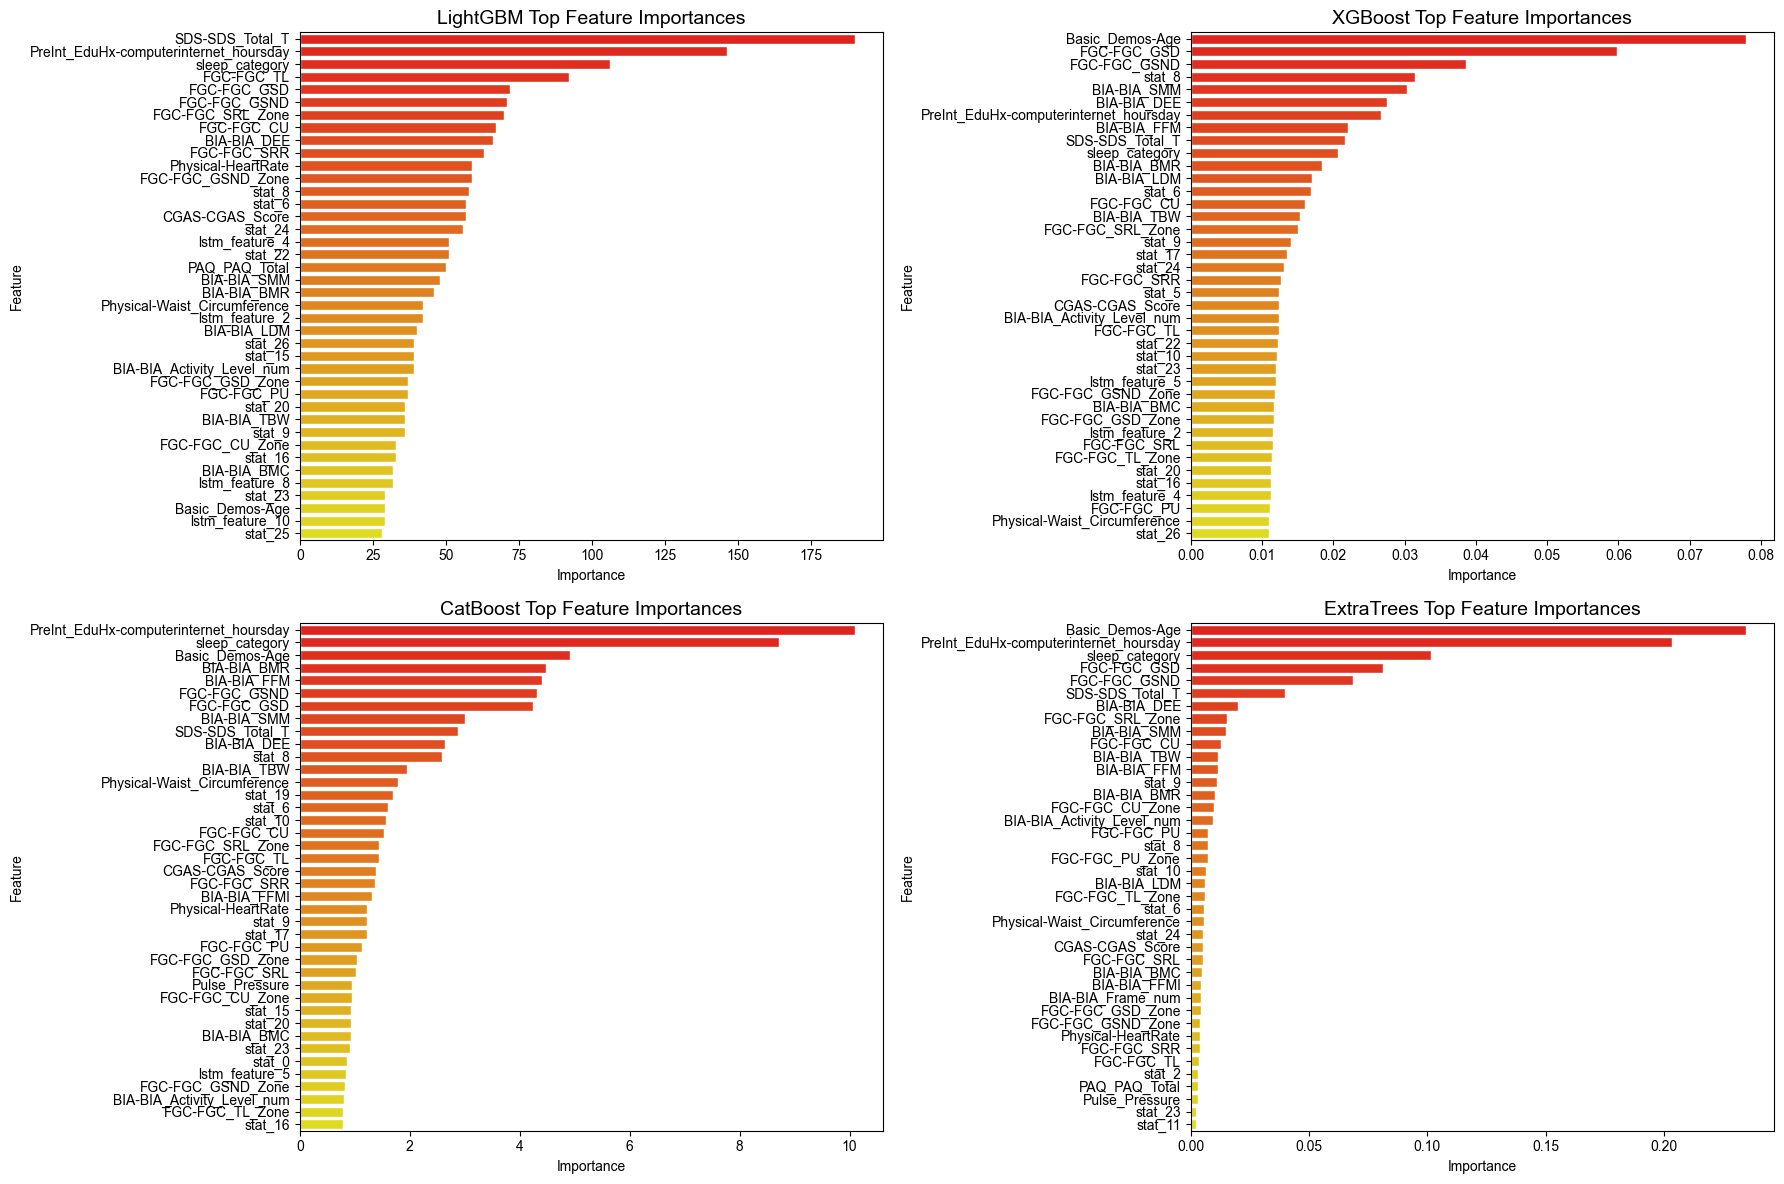

In [67]:
lgb_importances = pd.DataFrame({
    'Feature': lgb_features,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

xgb_importances = pd.DataFrame({
    'Feature': xgb_features,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

cat_importances = pd.DataFrame({
    'Feature': cat_features,
    'Importance': cat_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

xtrees_importances = pd.DataFrame({
    'Feature': reduced_features,
    'Importance': xtrees_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

n_top_features = 40

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
sns.set_theme(style="whitegrid")

sns.barplot(ax=axes[0, 0], data=lgb_importances.head(n_top_features),
            x='Importance', y='Feature', palette="autumn")
axes[0, 0].set_title('LightGBM Top Feature Importances', fontsize=14)
axes[0, 0].tick_params(axis='y', labelsize=10)

sns.barplot(ax=axes[0, 1], data=xgb_importances.head(n_top_features),
            x='Importance', y='Feature', palette="autumn")
axes[0, 1].set_title('XGBoost Top Feature Importances', fontsize=14)
axes[0, 1].tick_params(axis='y', labelsize=10)

sns.barplot(ax=axes[1, 0], data=cat_importances.head(n_top_features),
            x='Importance', y='Feature', palette="autumn")
axes[1, 0].set_title('CatBoost Top Feature Importances', fontsize=14)
axes[1, 0].tick_params(axis='y', labelsize=10)

sns.barplot(ax=axes[1, 1], data=xtrees_importances.head(n_top_features),
            x='Importance', y='Feature', palette="autumn")
axes[1, 1].set_title('ExtraTrees Top Feature Importances', fontsize=14)
axes[1, 1].tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()


In [68]:
(set(lgb_importances[-10:]["Feature"]) & set(xgb_importances[-10:]["Feature"]) & set(cat_importances[-10:]["Feature"]))

{'lstm_feature_3', 'stat_18'}

<div style="background-color:#fefefe;color:black;padding:10px;border:10px groove #d4b59c;border-radius:40px;">
  <p style="margin:10px 0;text-align:left;">
Her modelin tahminlerine belirlenen threshold değerleri uygulanarak yuvarlama yapılır. Ardından, ensembel sonuçlarında, tüm modellerin tahminlerinin çoğunluk oyu (mod) alınır, yani en sık tahmin edilen sonuç seçilir.hminlerin önceliklerini belirler.
  </p>
</div>

In [69]:
# Apply the optimized thresholds to test predictions
test_lgb = round_with_thresholds(test_lgb, lgb_thresholds_ens)
test_xgb = round_with_thresholds(test_xgb, xgb_thresholds_ens)
test_xgb_2 = round_with_thresholds(test_xgb_2, xgb_2_thresholds_ens)
test_cat = round_with_thresholds(test_cat, cat_thresholds_ens)
test_xtrees = round_with_thresholds(test_xtrees, xtrees_thresholds_ens)

test_preds = np.array([test_lgb, test_xgb, test_xgb_2, test_cat, test_xtrees])
voted_test = stats.mode(test_preds, axis=0).mode.flatten().astype(int)
final_test = np.round(voted_test).astype(int)

In [70]:
submission = pd.read_csv("sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)

In [71]:
submission

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,2
5,001f3379,1
6,0038ba98,0
7,0068a485,1
8,0069fbed,2
9,0083e397,2
